## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [3]:
# Importando as bibliotecas necessárias
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne

# Definições de filtros

# Função para aplicar um filtro passa-banda usando o método de Butterworth
def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    # Calcula os coeficientes do filtro
    b, a = signal.butter(order, [low, high], btype='bandpass')
    # Aplica o filtro aos dados
    return signal.filtfilt(b, a, data)

# Função para aplicar um filtro passa-baixa usando o método de Butterworth
def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    # Calcula os coeficientes do filtro
    b, a = signal.butter(order, low, btype='lowpass')
    # Aplica o filtro aos dados
    return signal.filtfilt(b, a, data)

# Função para aplicar um filtro passa-alta usando o método de Butterworth
def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    # Calcula os coeficientes do filtro
    b, a = signal.butter(order, high, btype='highpass')
    # Aplica o filtro aos dados
    return signal.filtfilt(b, a, data)

# Função para aplicar um filtro notch (rejeição de frequência) usando o método de Butterworth
def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    # Calcula os coeficientes do filtro
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    # Aplica o filtro aos dados
    return signal.filtfilt(b, a, data)


Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [6]:
def print_graphs(data):
    for i in range(0, 21, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 21, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 21, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [4]:
data = np.load("../../datasets/avi/multi/dataMulti_sub1.npy")
print(data.shape)

# Reorganizando os dados para a forma desejada
data = data.reshape(-1, data.shape[-1])
print(data.shape)

(100, 8192)
(100, 8192)


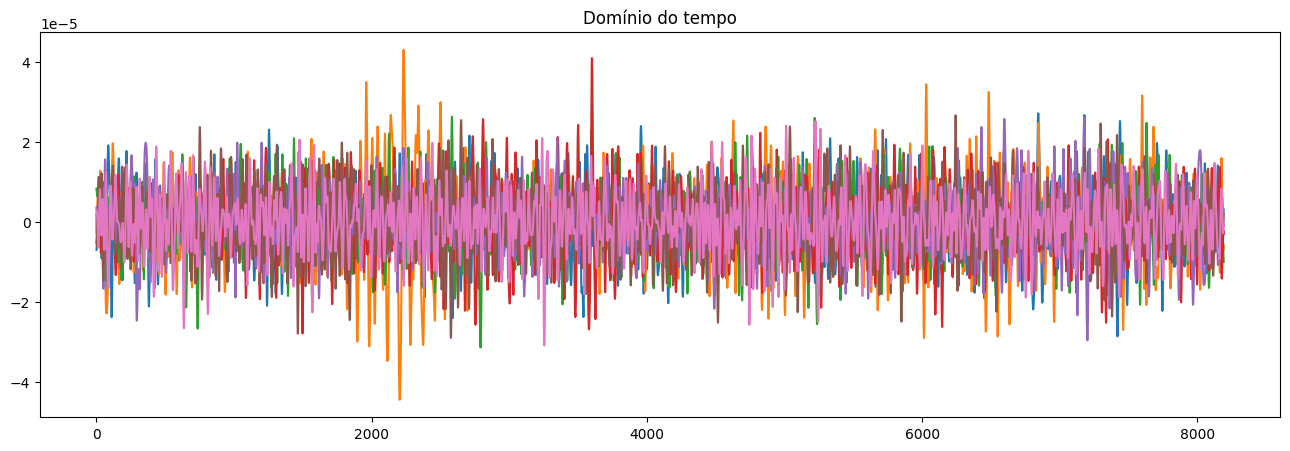

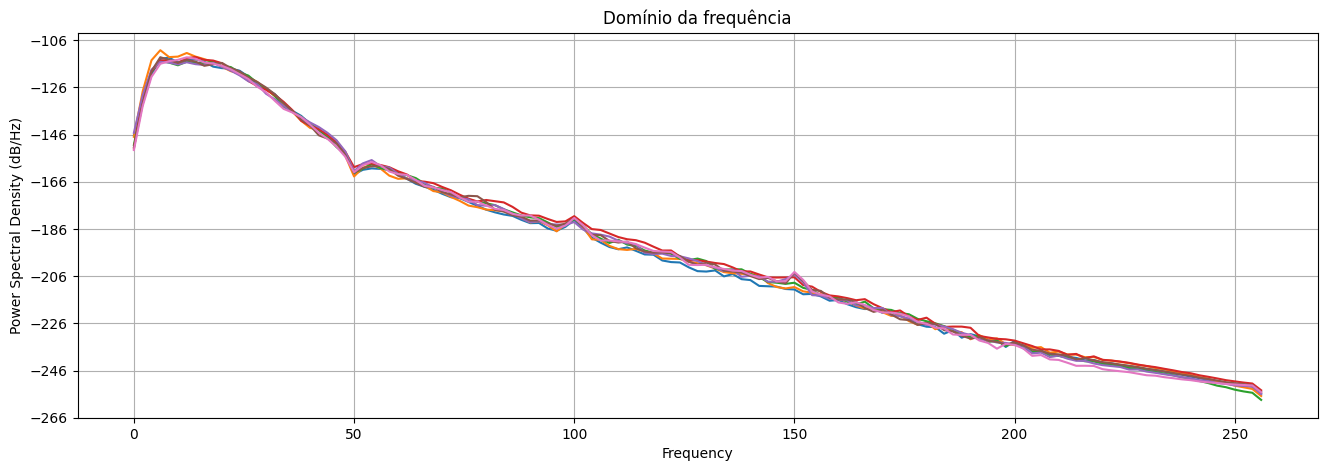

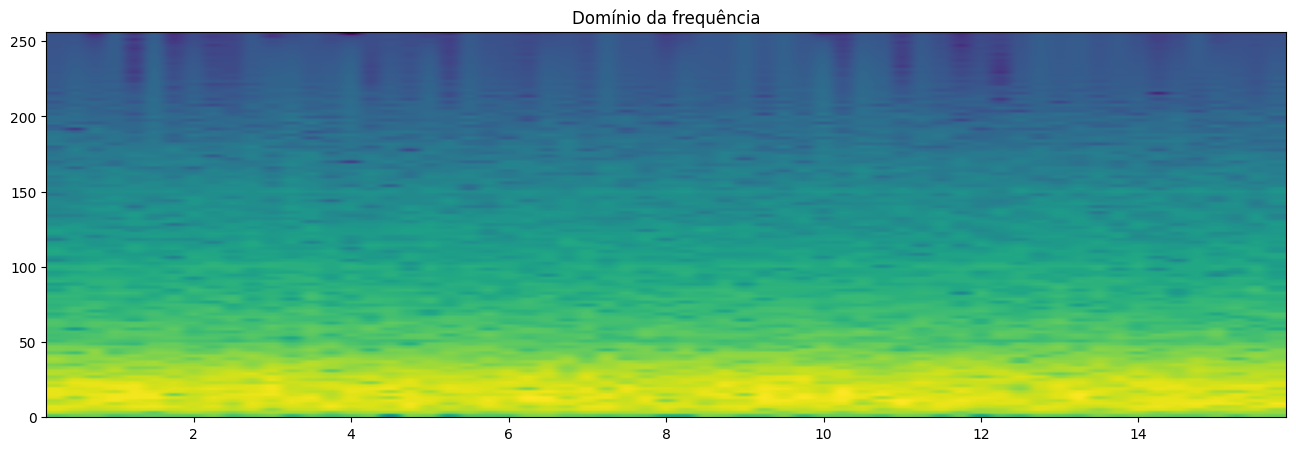

In [7]:
# definição dos tamanhos das figuras
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

In [8]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512 #64 beta; 512 amostras serão registradas pors egundo (2x256)
ch_names = ['Oz'] 
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [9]:
# Inicializa uma lista vazia para armazenar objetos do tipo 'mne'
mne_list = []

labels = np.load("../../datasets/avi/multi/labelsMulti_sub1.npy")

data = np.load("../../datasets/avi/multi/dataMulti_sub1.npy")

# Redimensiona os dados para ter uma dimensão extra
data_correct = data.reshape(data.shape[0], 1, data.shape[1])

# Inicializa um codificador de rótulos (LabelEncoder)
le = LabelEncoder()

# Cria um array de eventos que inclui um índice, zeros e os rótulos codificados
events = np.column_stack((
    np.array(range(len(labels))),  # Índices dos eventos
    np.zeros(100, dtype=int),     # Números zero
    le.fit_transform(labels)))     # Rótulos codificados

# Define um dicionário que mapeia rótulos para identificadores de eventos
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5}

# Cria um objeto 'mne.EpochsArray' com os dados, informações, eventos e o mapeamento de eventos
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)

# Aplica um filtro passa-banda (band-pass) nos dados para restringir as frequências entre 4Hz e 12Hz
combined_epochs = mne_data.filter(l_freq=4., h_freq=12)

# Salva os dados filtrados em um arquivo .fif
combined_epochs.save(fname="../../datasets/avi/multi/sub1_combined-raw.fif", overwrite=True)


Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)

Overwriting existing file.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
/tmp/ipykernel_19772/704459762.py:32: RuntimeWarning: This filename (../../datasets/avi/multi/sub1_combined-raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  combined_epochs.save(fname="../../datasets/avi/multi/sub1_combined-raw.fif", overwrite=True)


Need more than one channel to make topography for eeg. Disabling interactivity.



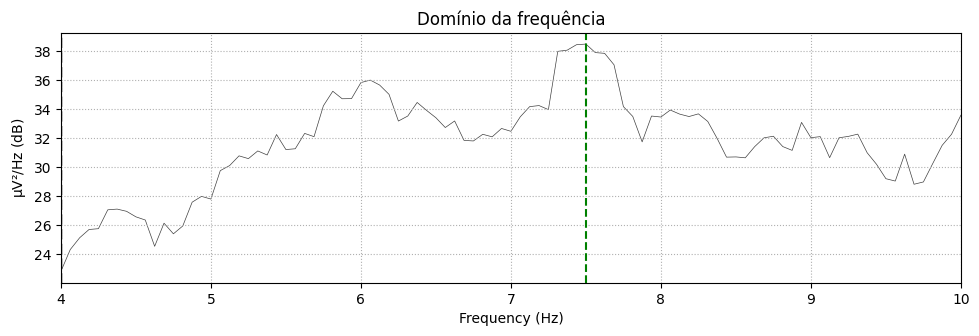

Need more than one channel to make topography for eeg. Disabling interactivity.



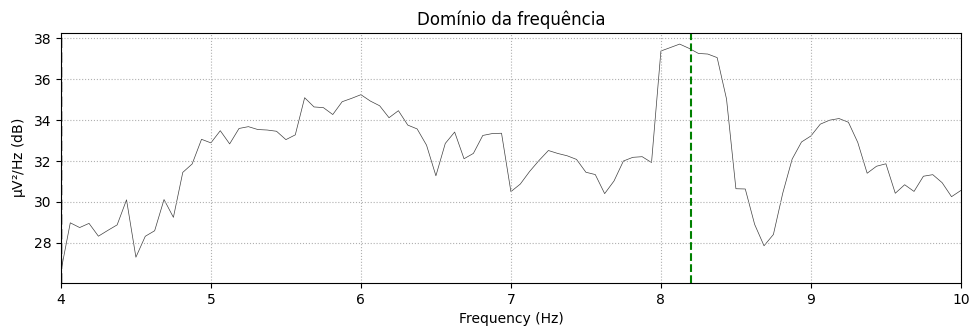

Need more than one channel to make topography for eeg. Disabling interactivity.



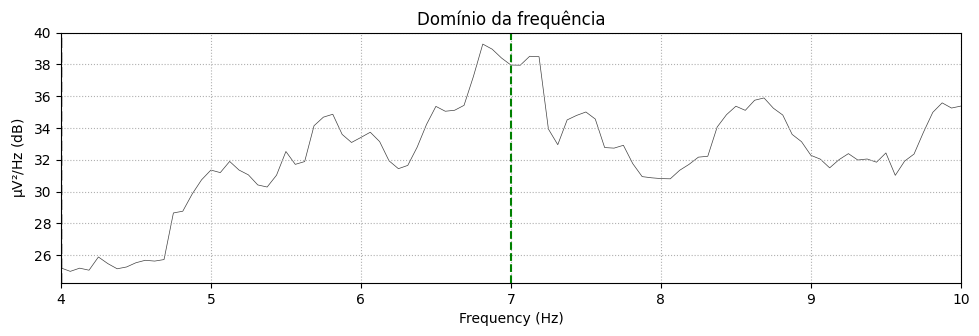

Need more than one channel to make topography for eeg. Disabling interactivity.



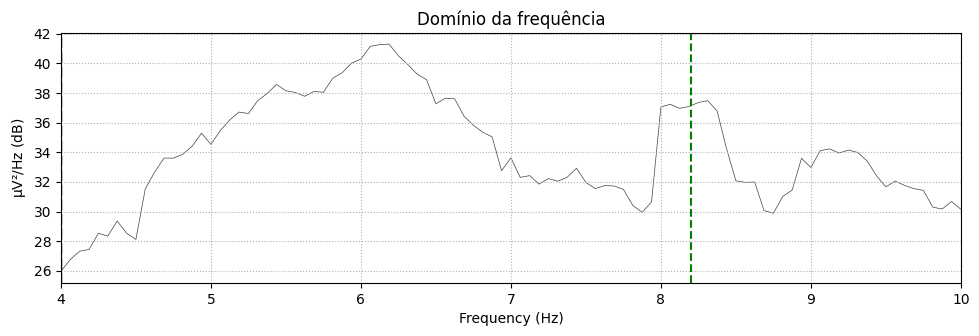

Need more than one channel to make topography for eeg. Disabling interactivity.



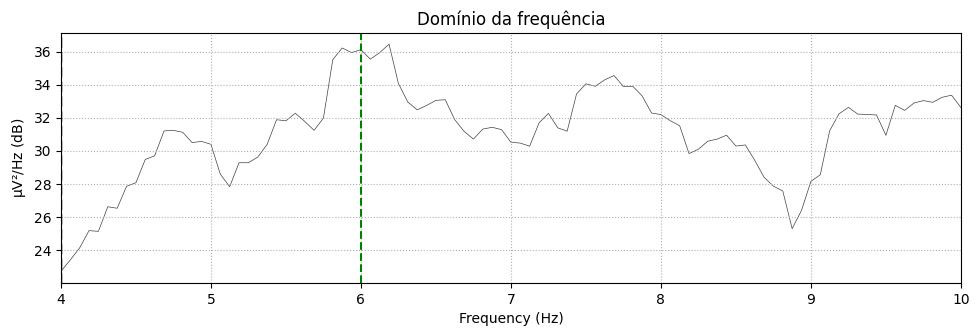

Need more than one channel to make topography for eeg. Disabling interactivity.



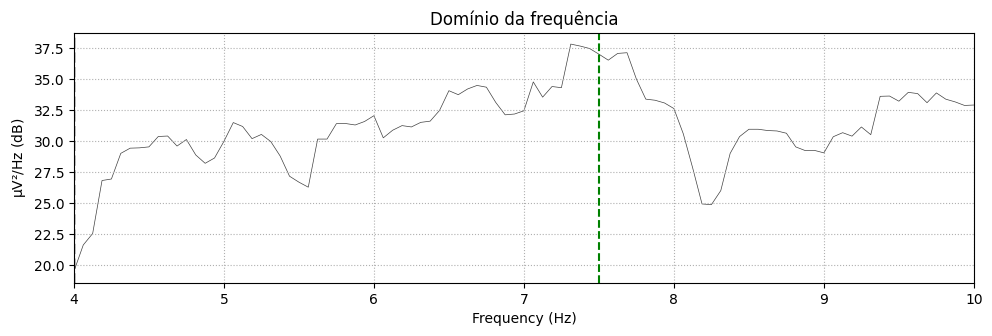

Need more than one channel to make topography for eeg. Disabling interactivity.



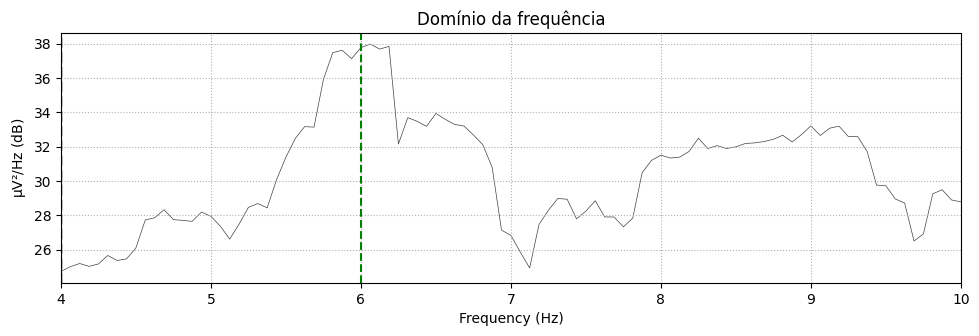

Need more than one channel to make topography for eeg. Disabling interactivity.



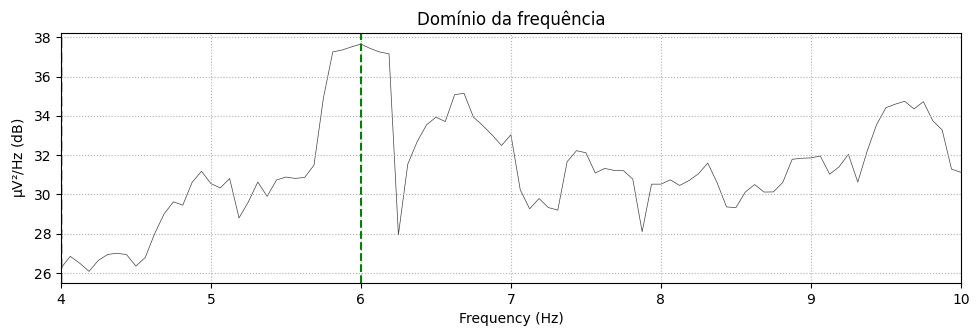

Need more than one channel to make topography for eeg. Disabling interactivity.



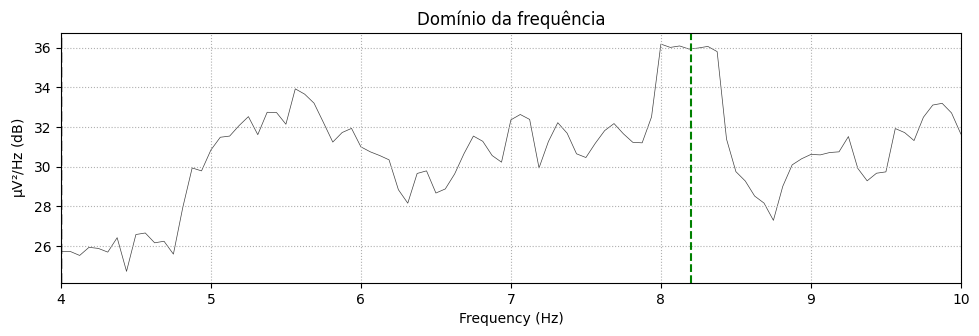

Need more than one channel to make topography for eeg. Disabling interactivity.



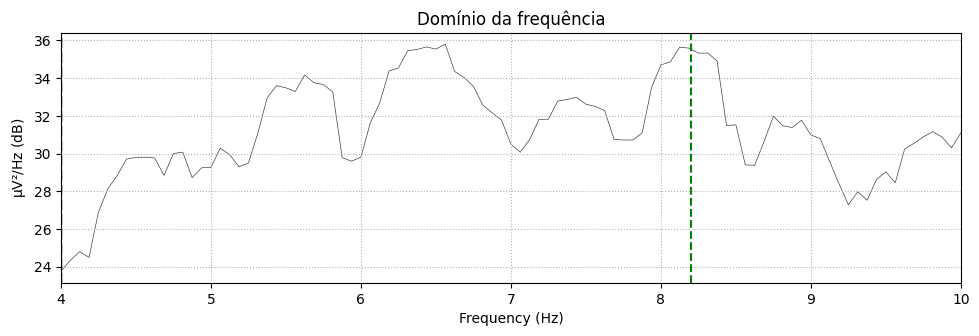

Need more than one channel to make topography for eeg. Disabling interactivity.



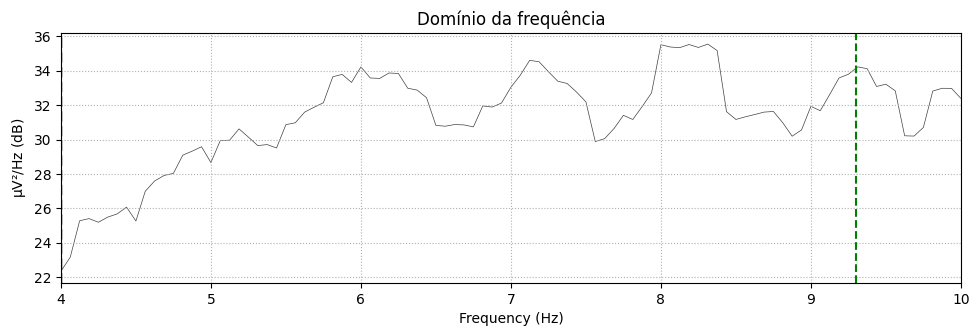

Need more than one channel to make topography for eeg. Disabling interactivity.



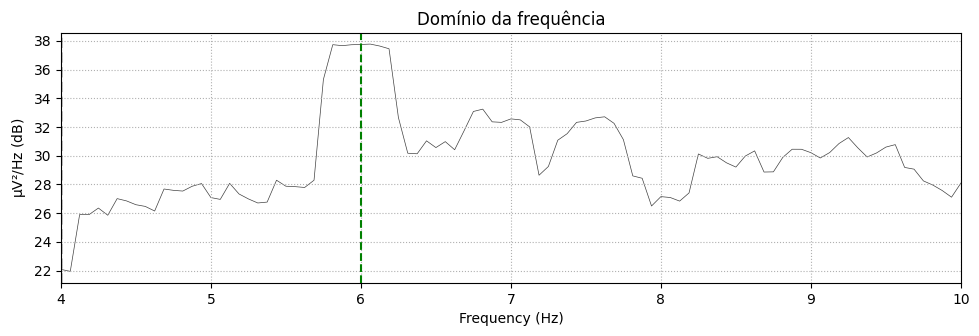

Need more than one channel to make topography for eeg. Disabling interactivity.



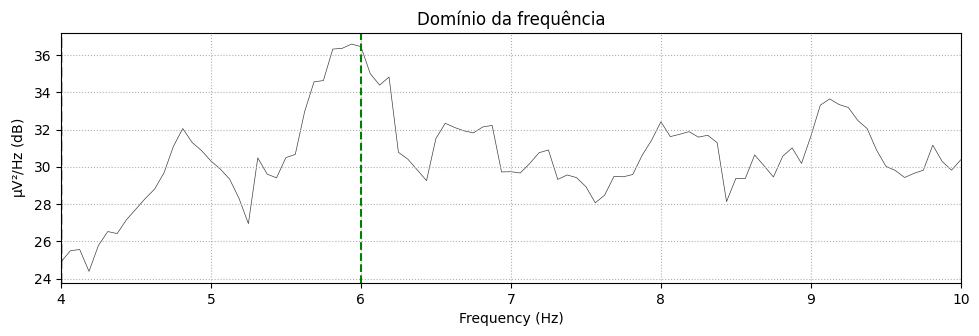

Need more than one channel to make topography for eeg. Disabling interactivity.



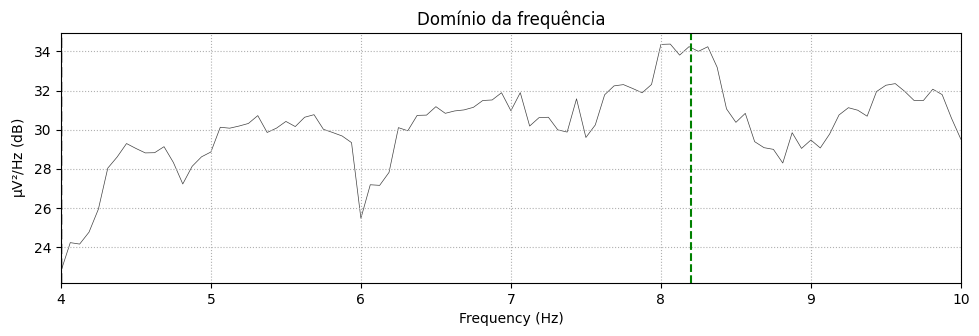

Need more than one channel to make topography for eeg. Disabling interactivity.



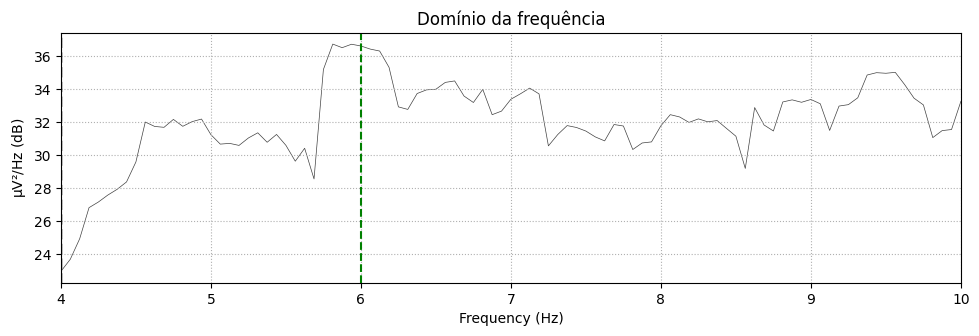

Need more than one channel to make topography for eeg. Disabling interactivity.



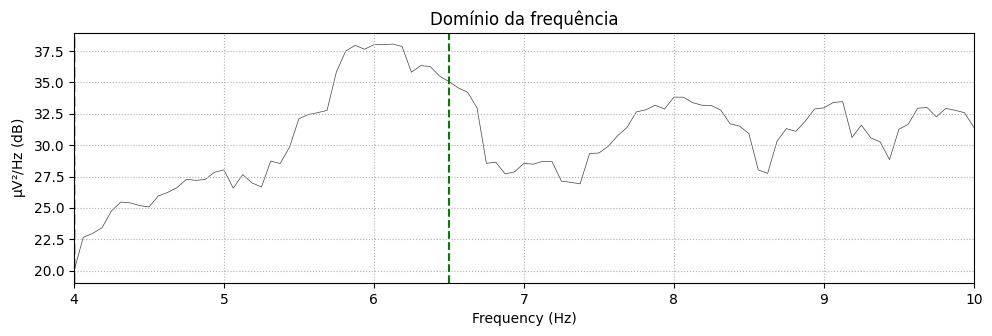

Need more than one channel to make topography for eeg. Disabling interactivity.



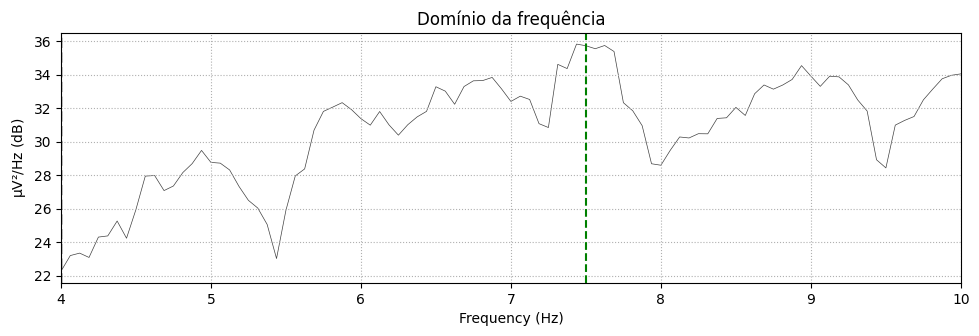

Need more than one channel to make topography for eeg. Disabling interactivity.



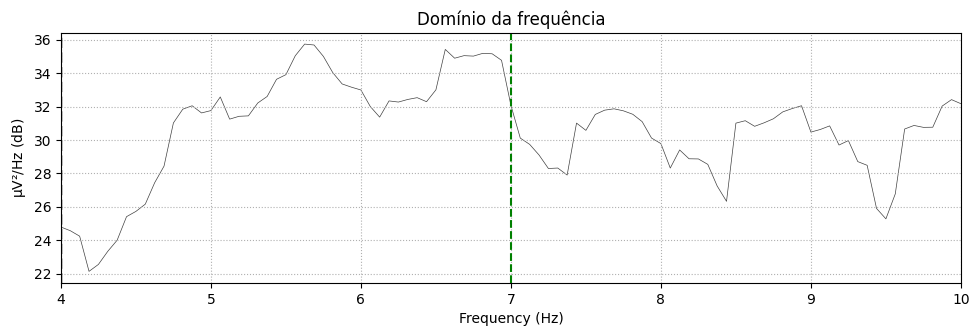

Need more than one channel to make topography for eeg. Disabling interactivity.



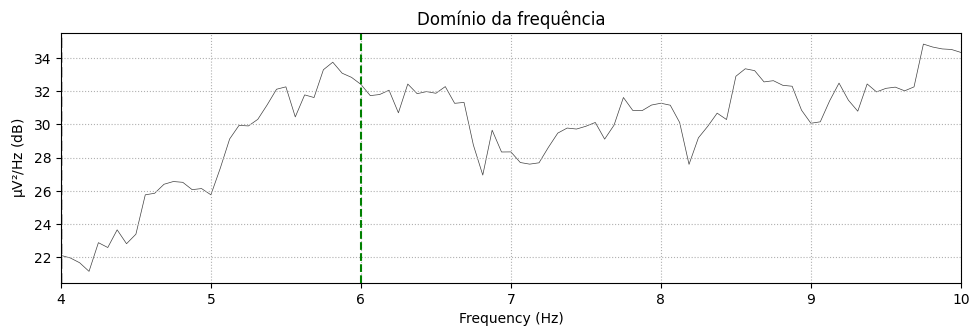

Need more than one channel to make topography for eeg. Disabling interactivity.



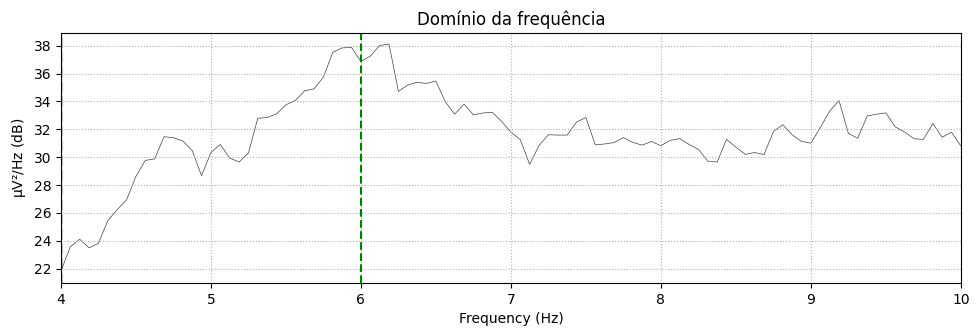

Need more than one channel to make topography for eeg. Disabling interactivity.



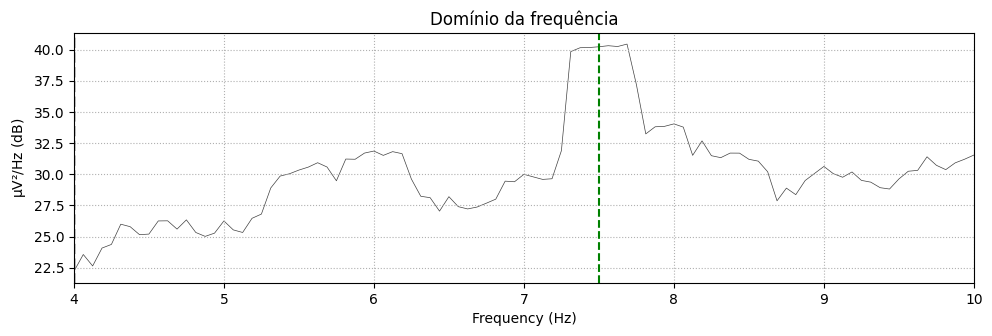

Need more than one channel to make topography for eeg. Disabling interactivity.



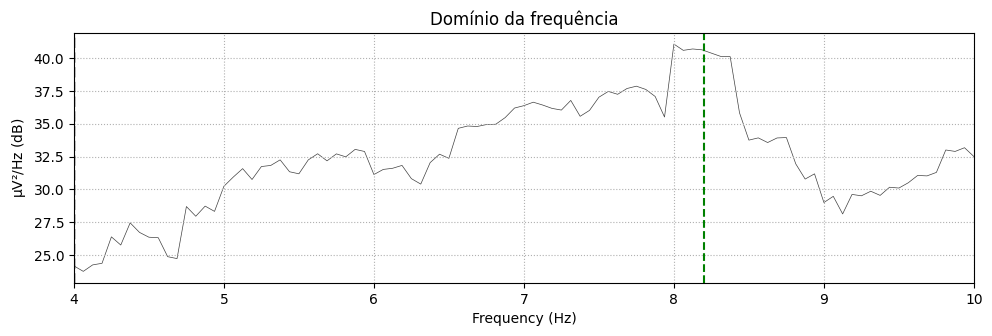

Need more than one channel to make topography for eeg. Disabling interactivity.



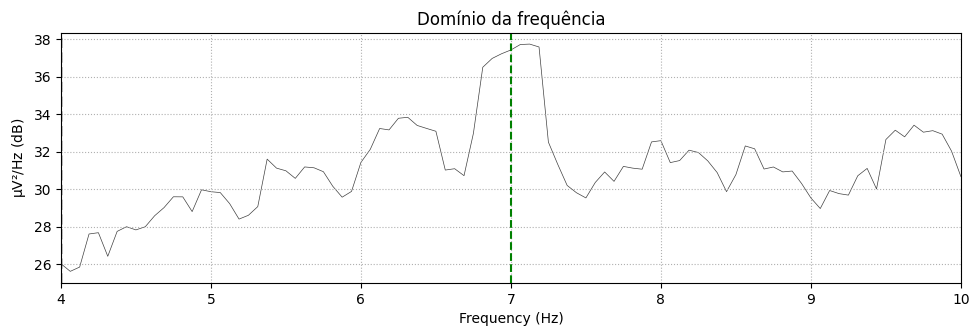

Need more than one channel to make topography for eeg. Disabling interactivity.



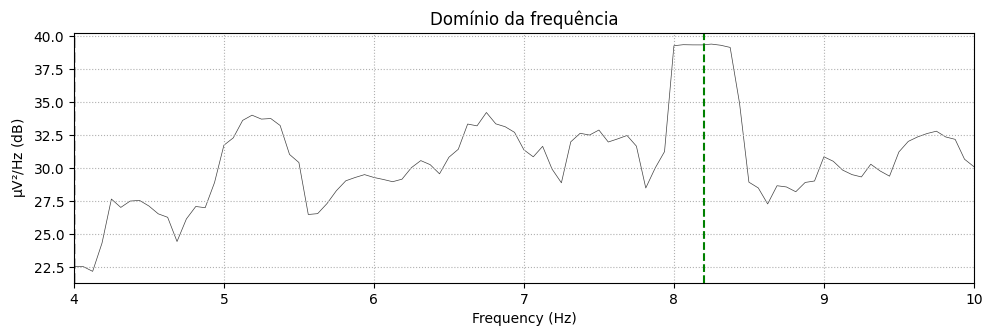

Need more than one channel to make topography for eeg. Disabling interactivity.



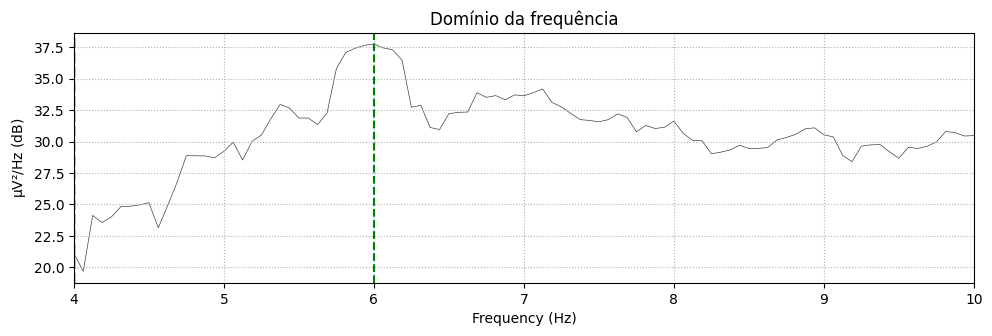

Need more than one channel to make topography for eeg. Disabling interactivity.



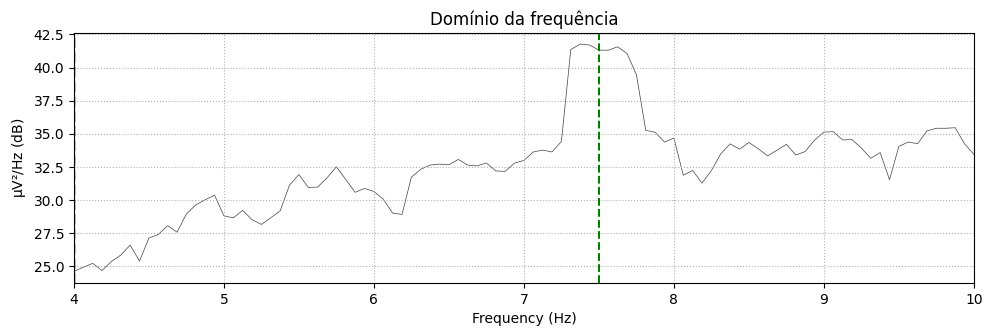

Need more than one channel to make topography for eeg. Disabling interactivity.



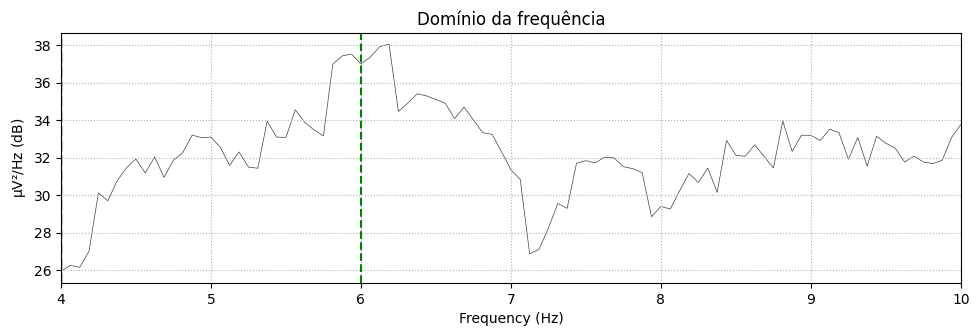

Need more than one channel to make topography for eeg. Disabling interactivity.



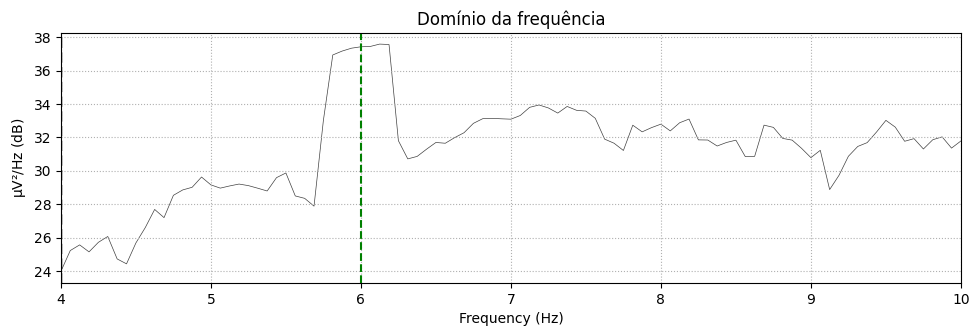

Need more than one channel to make topography for eeg. Disabling interactivity.



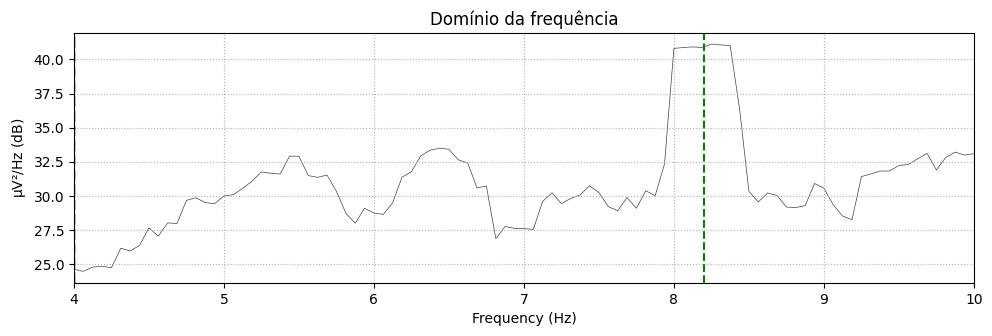

Need more than one channel to make topography for eeg. Disabling interactivity.



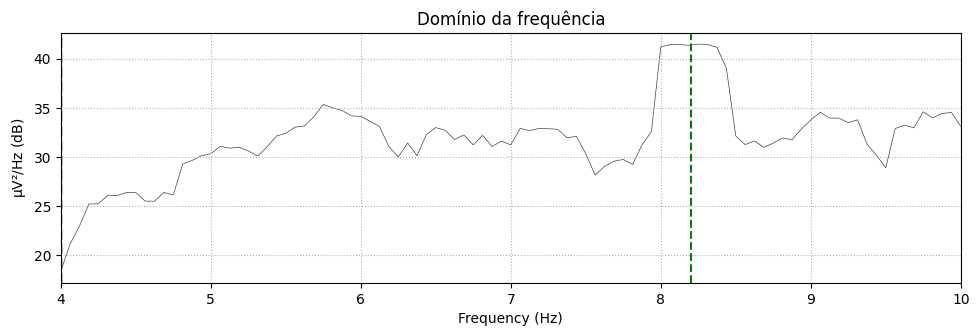

Need more than one channel to make topography for eeg. Disabling interactivity.



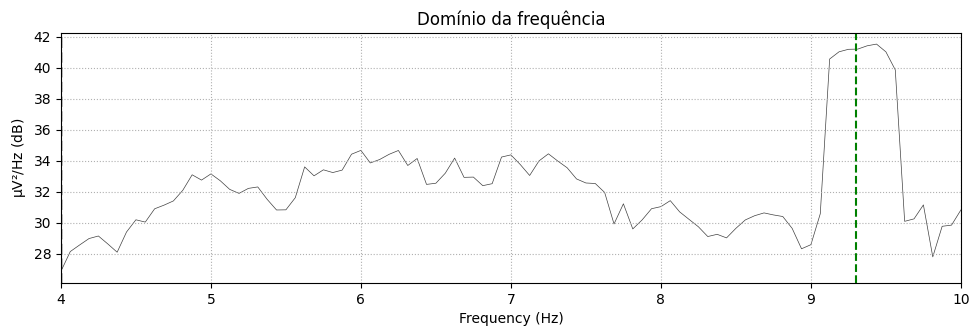

Need more than one channel to make topography for eeg. Disabling interactivity.



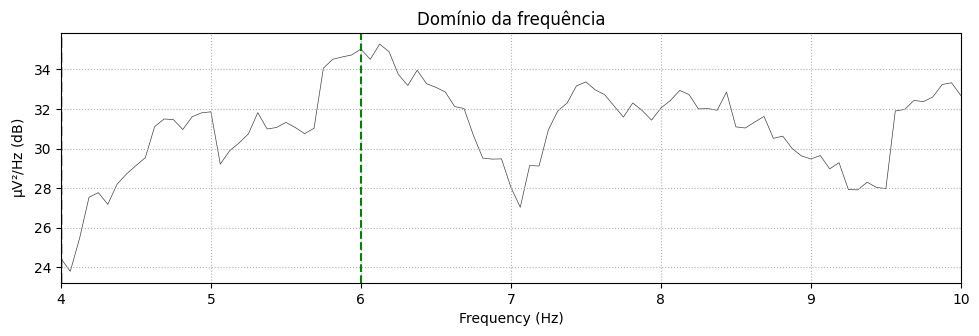

Need more than one channel to make topography for eeg. Disabling interactivity.



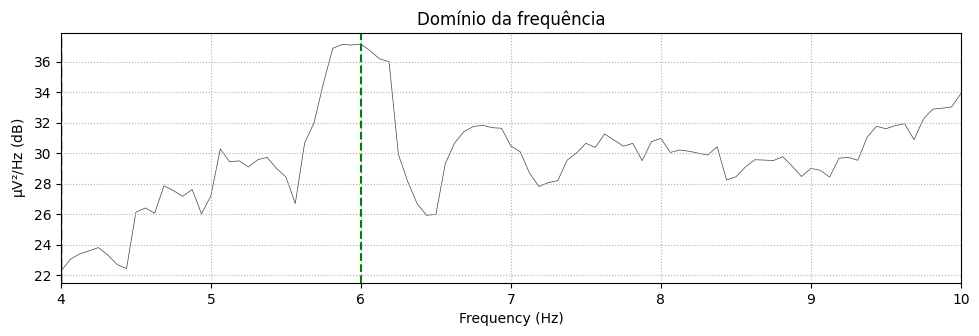

Need more than one channel to make topography for eeg. Disabling interactivity.



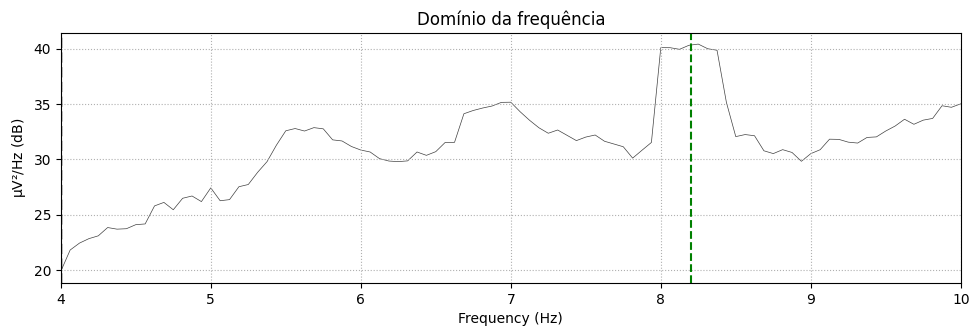

Need more than one channel to make topography for eeg. Disabling interactivity.



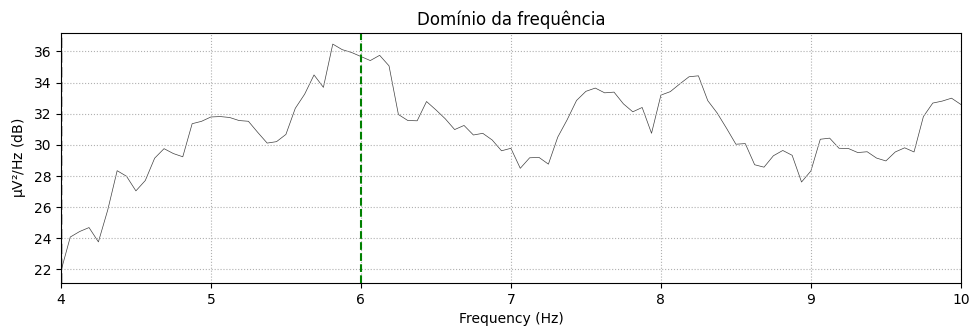

Need more than one channel to make topography for eeg. Disabling interactivity.



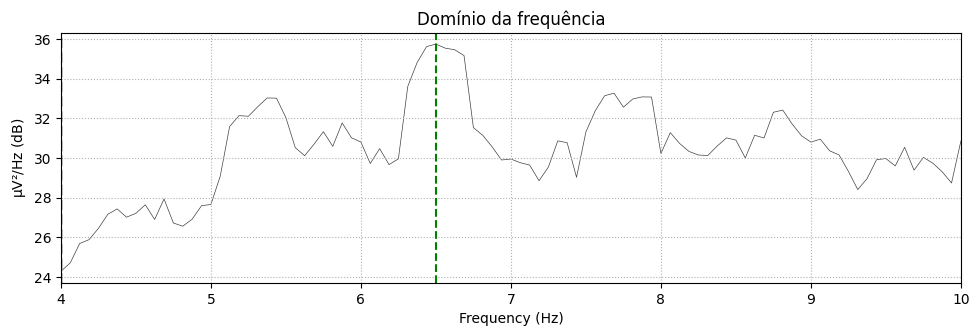

Need more than one channel to make topography for eeg. Disabling interactivity.



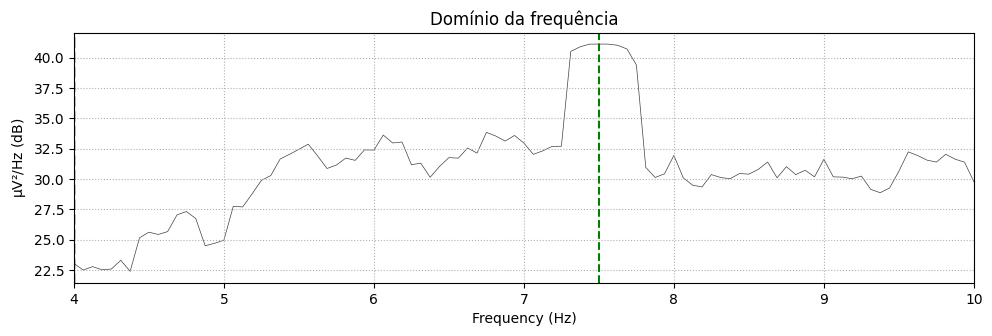

Need more than one channel to make topography for eeg. Disabling interactivity.



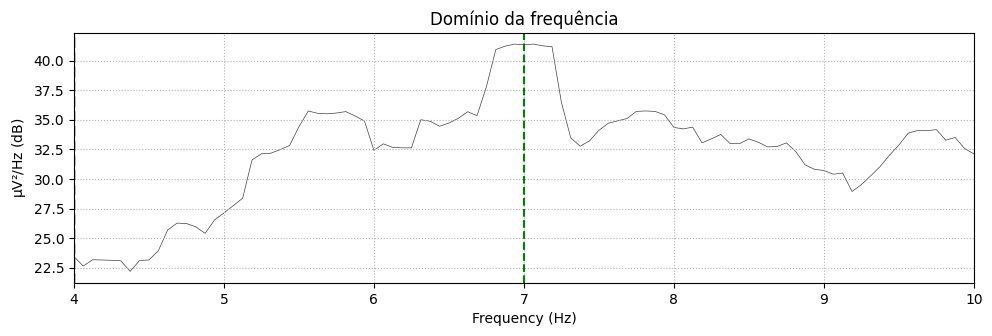

Need more than one channel to make topography for eeg. Disabling interactivity.



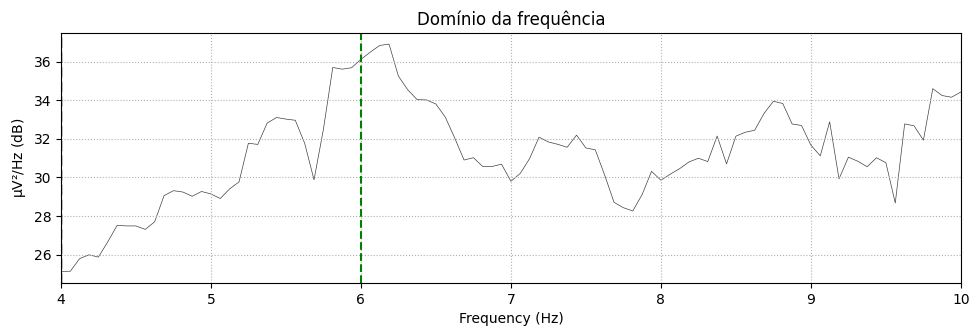

Need more than one channel to make topography for eeg. Disabling interactivity.



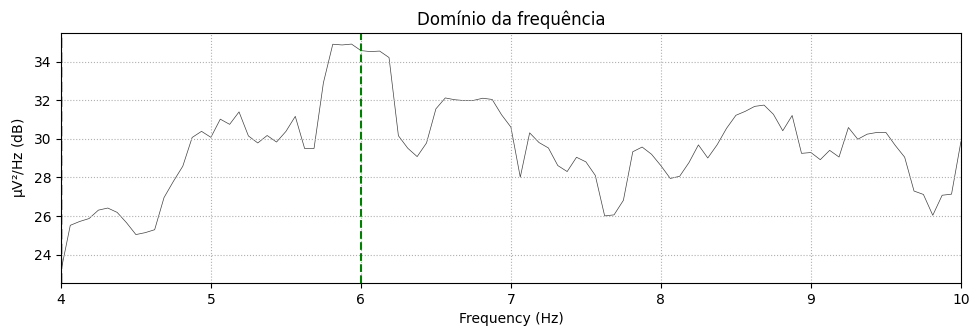

Need more than one channel to make topography for eeg. Disabling interactivity.



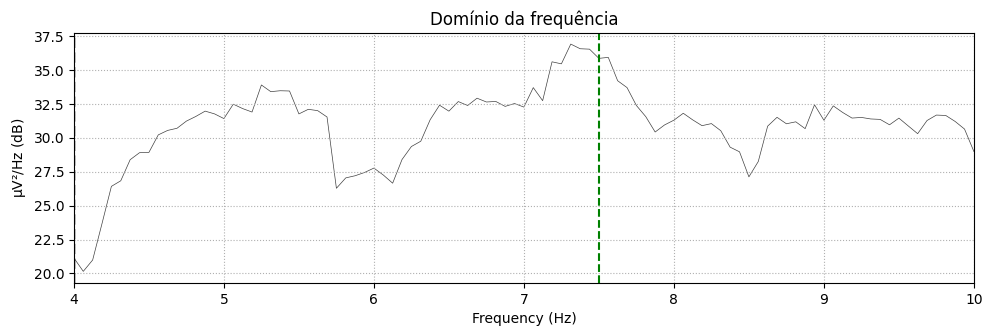

Need more than one channel to make topography for eeg. Disabling interactivity.



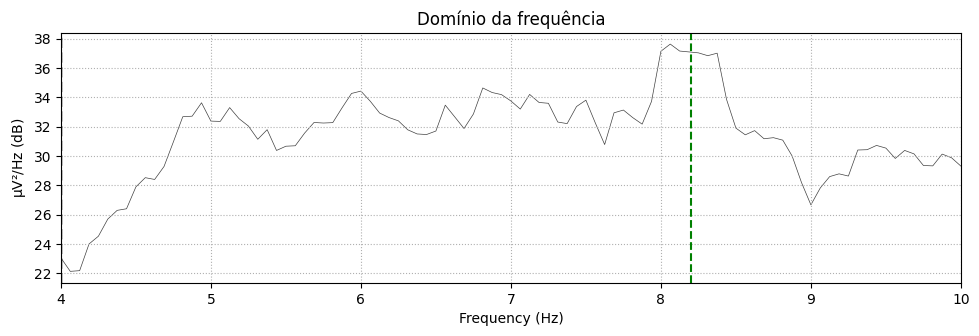

Need more than one channel to make topography for eeg. Disabling interactivity.



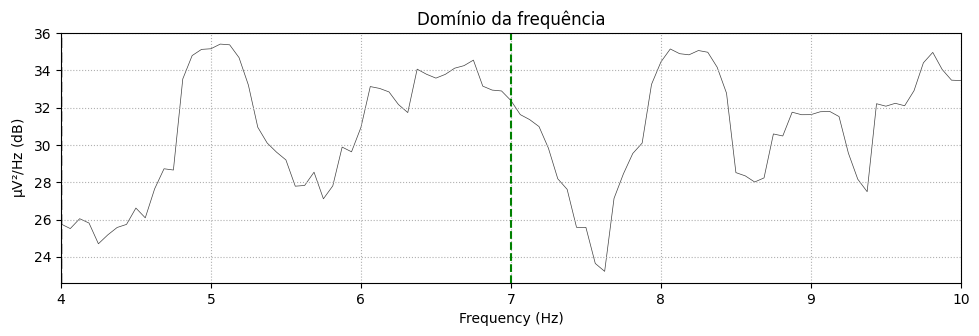

Need more than one channel to make topography for eeg. Disabling interactivity.



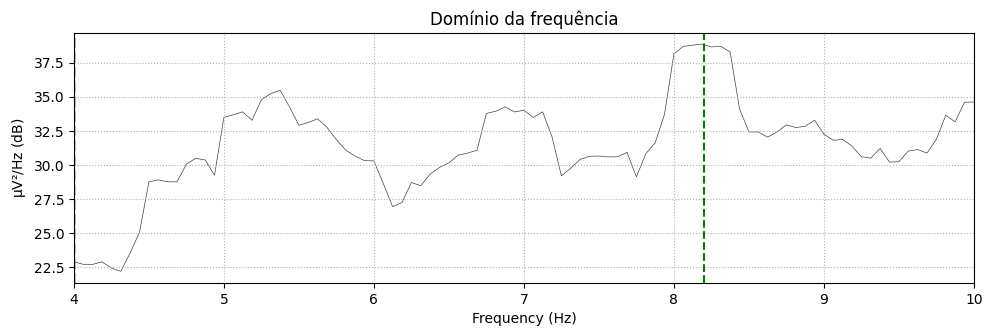

Need more than one channel to make topography for eeg. Disabling interactivity.



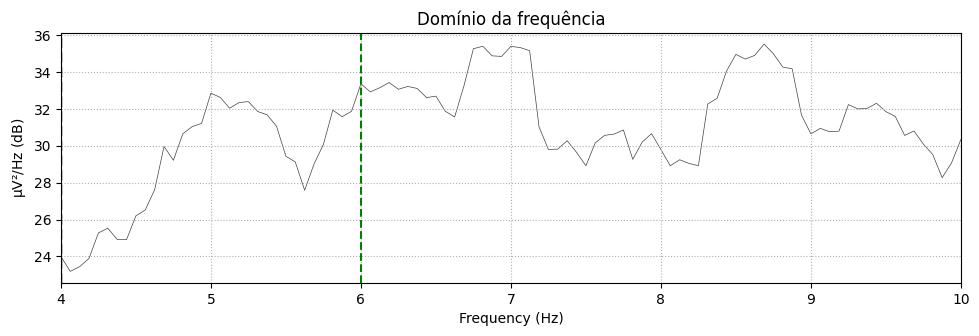

Need more than one channel to make topography for eeg. Disabling interactivity.



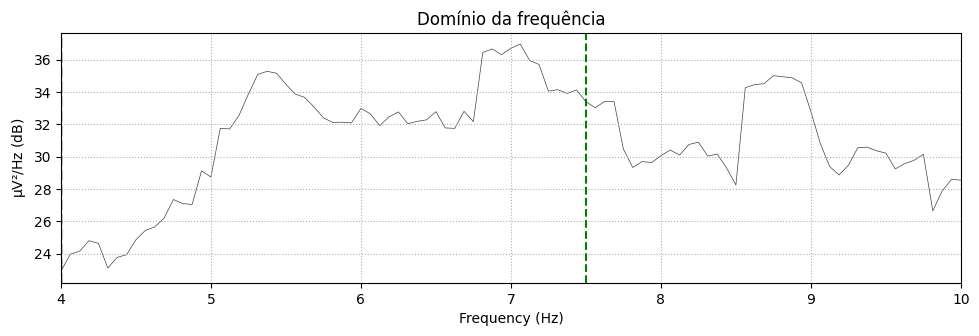

Need more than one channel to make topography for eeg. Disabling interactivity.



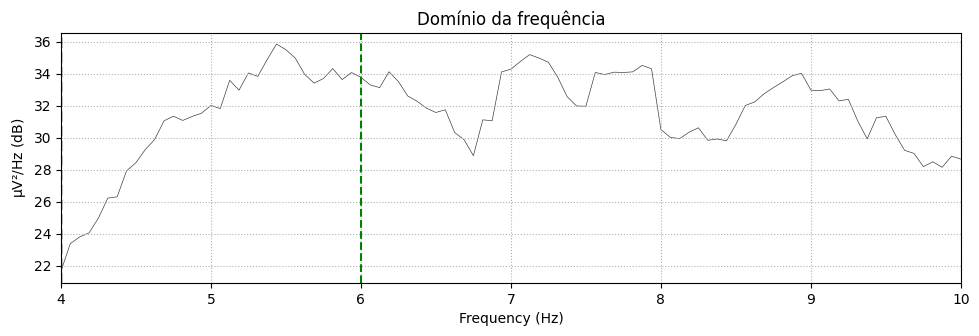

Need more than one channel to make topography for eeg. Disabling interactivity.



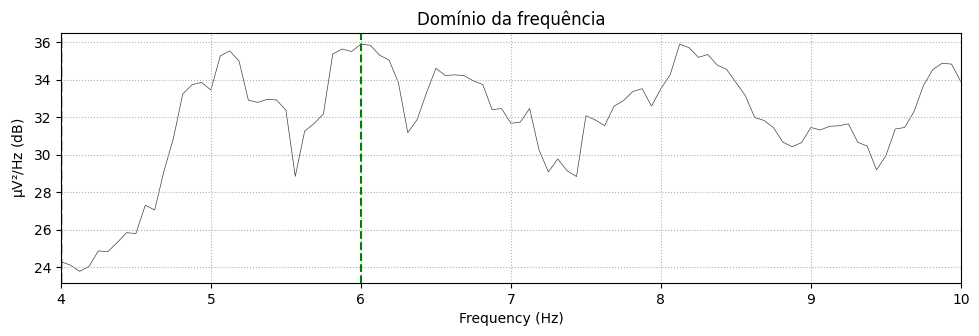

Need more than one channel to make topography for eeg. Disabling interactivity.



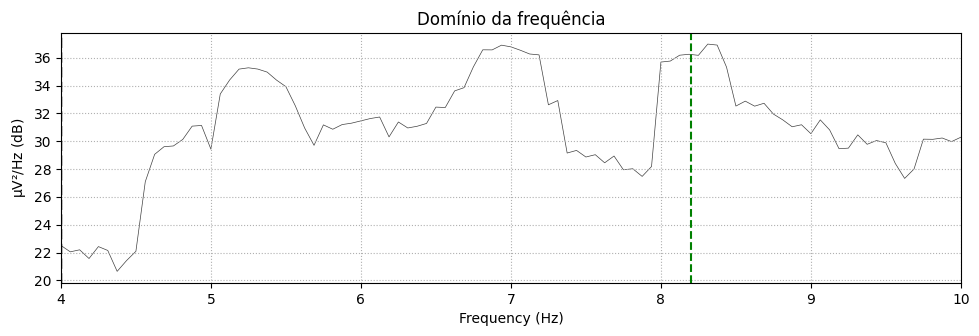

Need more than one channel to make topography for eeg. Disabling interactivity.



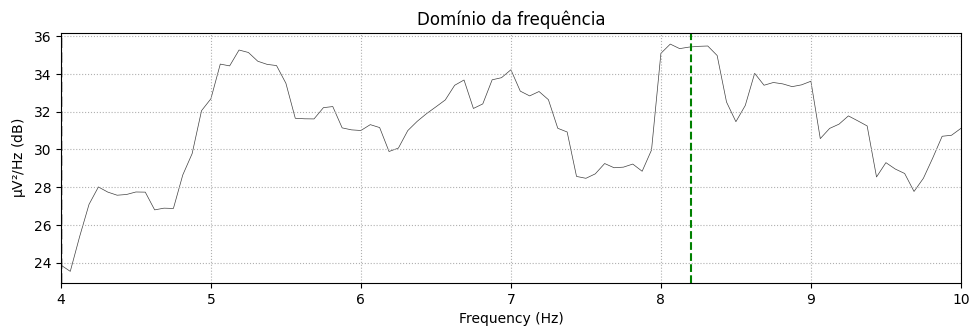

Need more than one channel to make topography for eeg. Disabling interactivity.



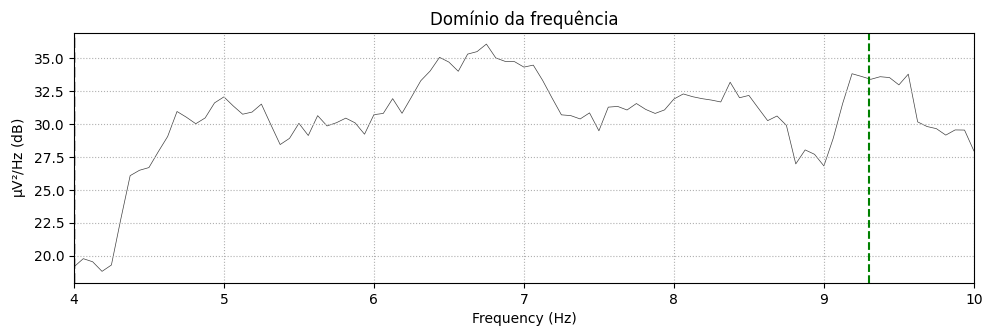

Need more than one channel to make topography for eeg. Disabling interactivity.



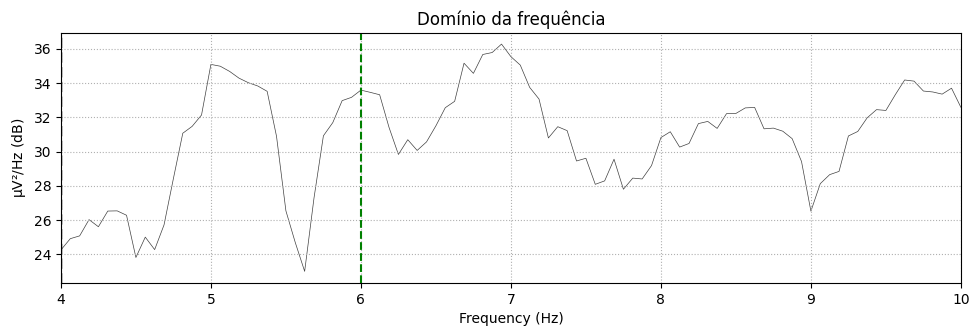

Need more than one channel to make topography for eeg. Disabling interactivity.



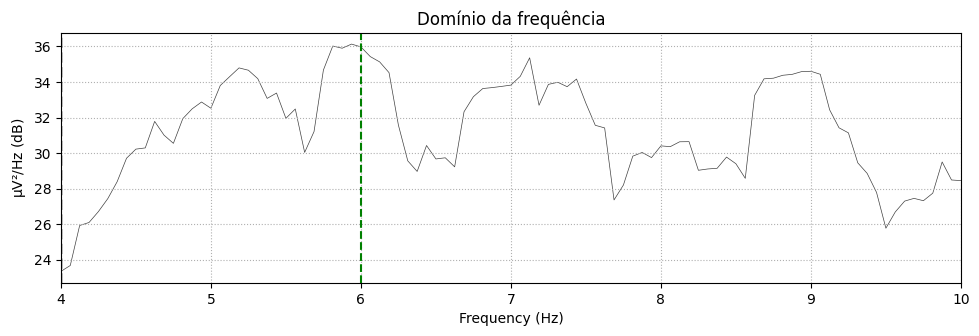

Need more than one channel to make topography for eeg. Disabling interactivity.



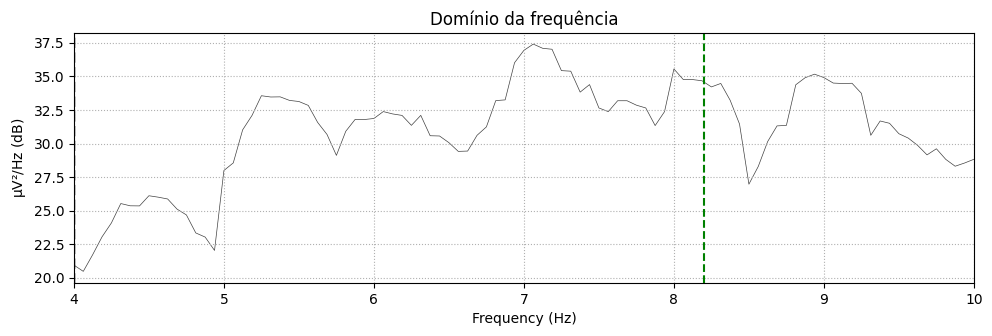

Need more than one channel to make topography for eeg. Disabling interactivity.



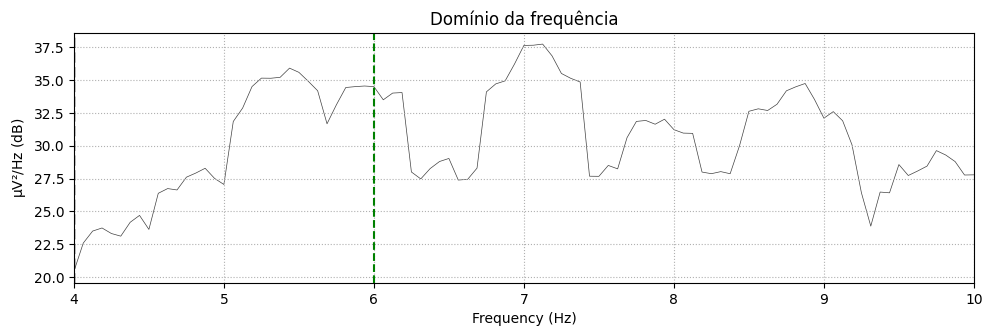

Need more than one channel to make topography for eeg. Disabling interactivity.



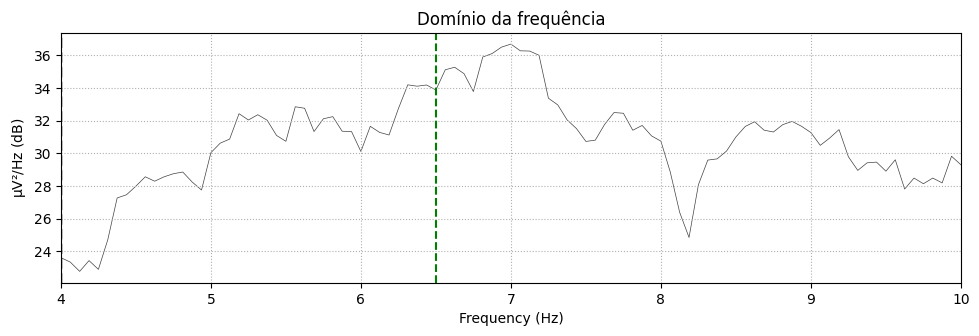

Need more than one channel to make topography for eeg. Disabling interactivity.



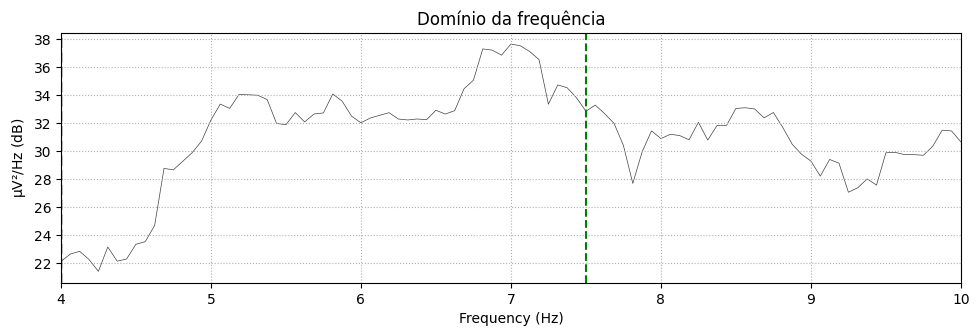

Need more than one channel to make topography for eeg. Disabling interactivity.



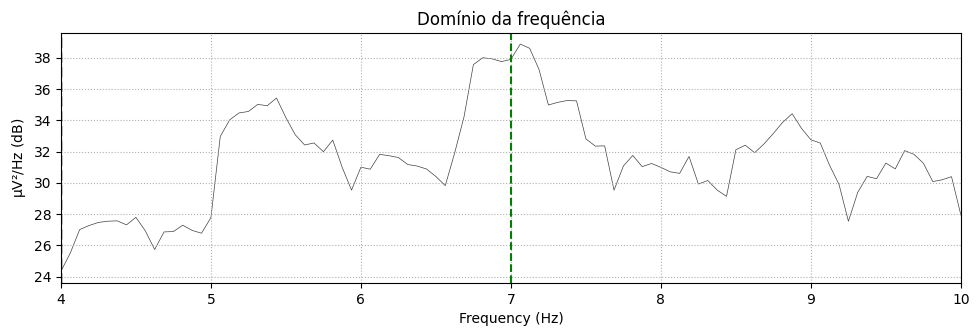

Need more than one channel to make topography for eeg. Disabling interactivity.



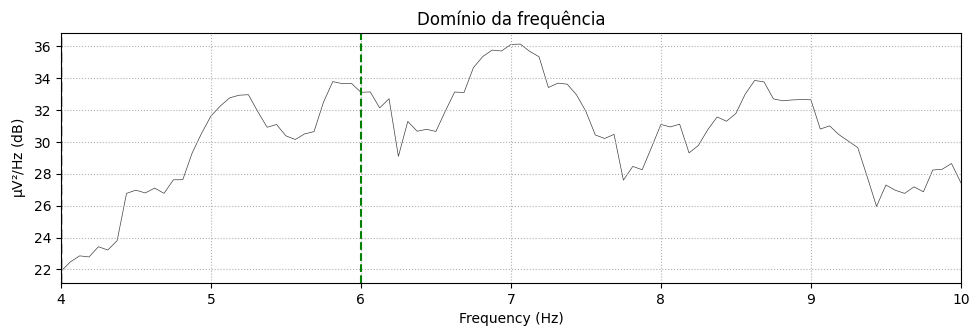

Need more than one channel to make topography for eeg. Disabling interactivity.



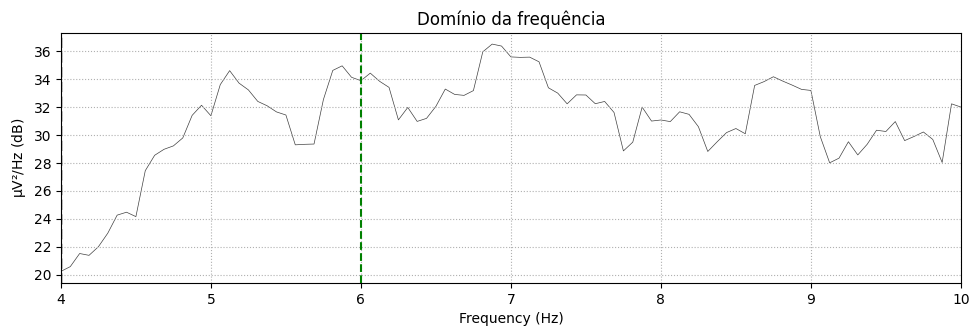

Need more than one channel to make topography for eeg. Disabling interactivity.



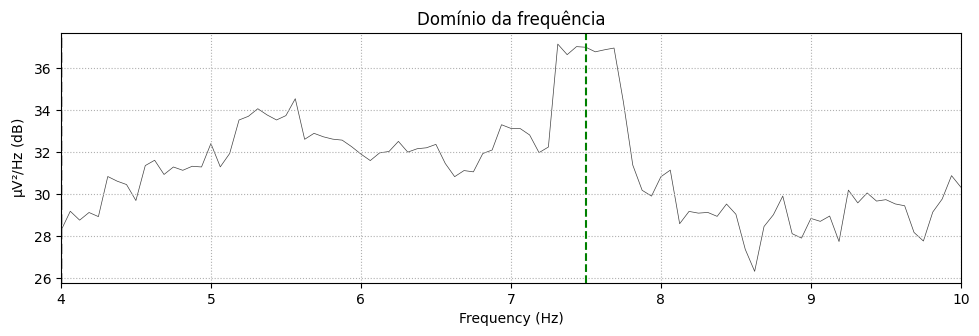

Need more than one channel to make topography for eeg. Disabling interactivity.



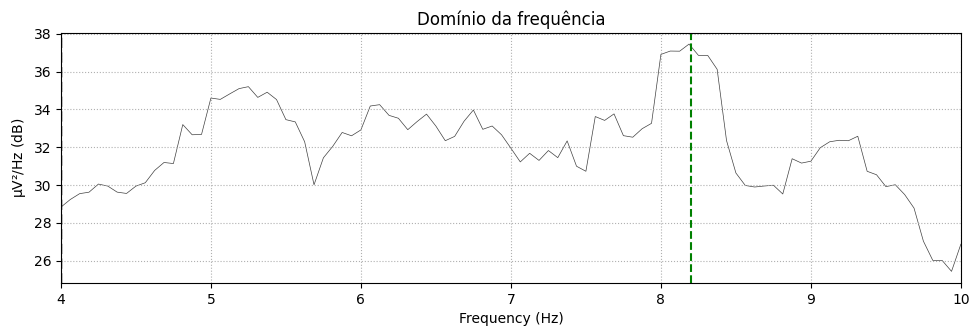

Need more than one channel to make topography for eeg. Disabling interactivity.



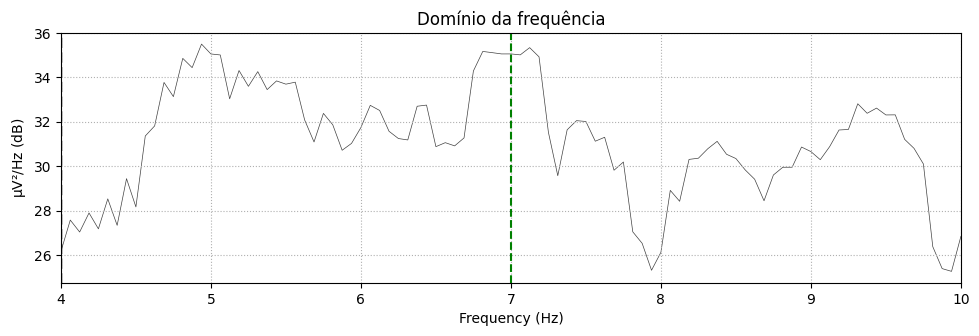

Need more than one channel to make topography for eeg. Disabling interactivity.



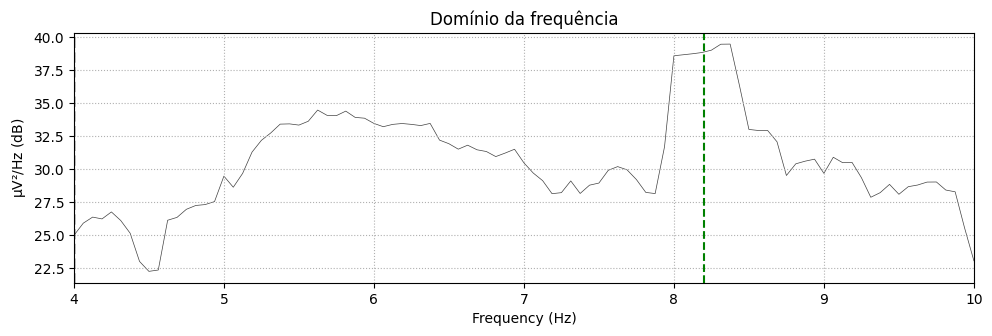

Need more than one channel to make topography for eeg. Disabling interactivity.



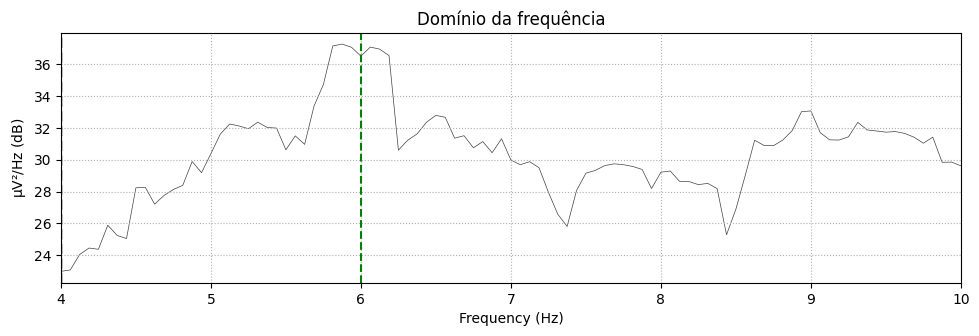

Need more than one channel to make topography for eeg. Disabling interactivity.



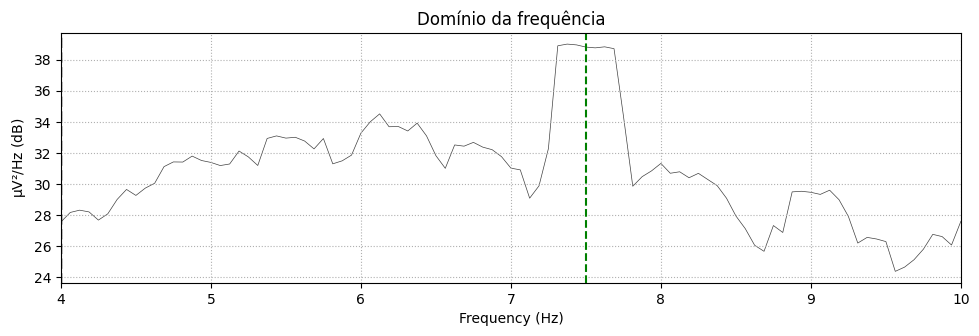

Need more than one channel to make topography for eeg. Disabling interactivity.



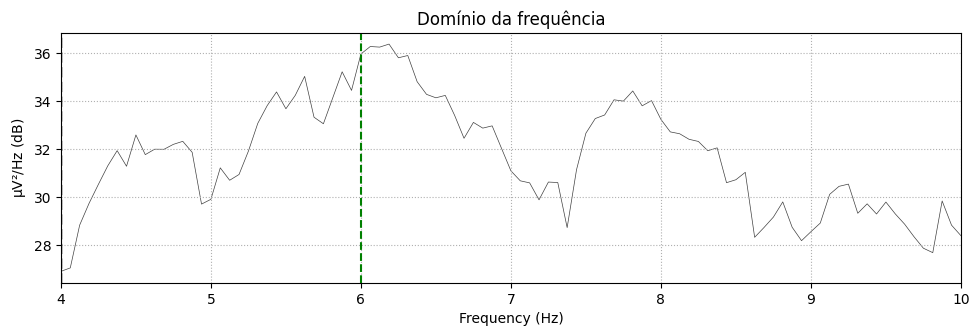

Need more than one channel to make topography for eeg. Disabling interactivity.



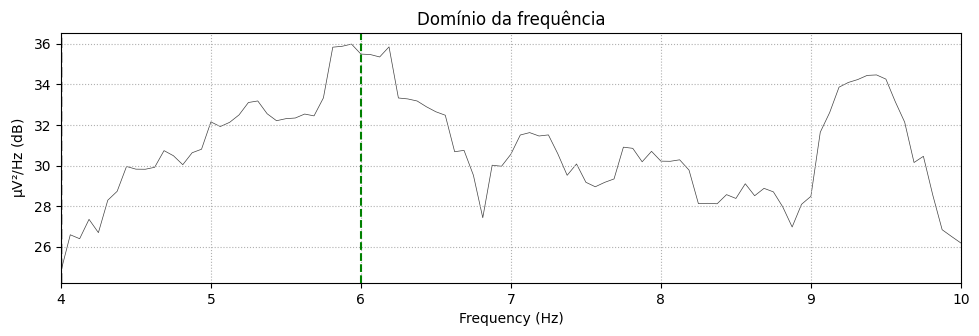

Need more than one channel to make topography for eeg. Disabling interactivity.



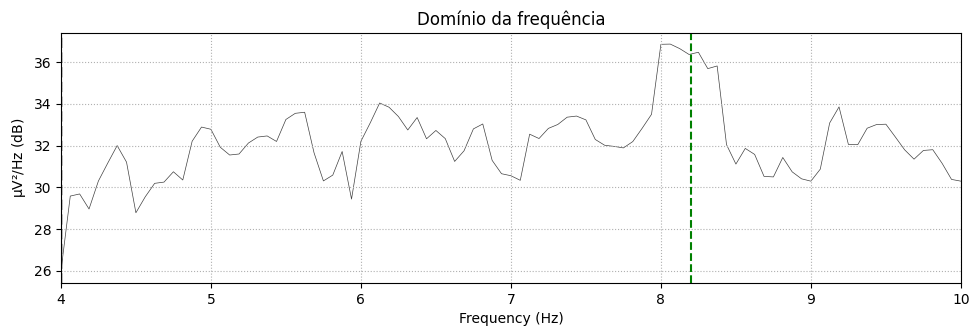

Need more than one channel to make topography for eeg. Disabling interactivity.



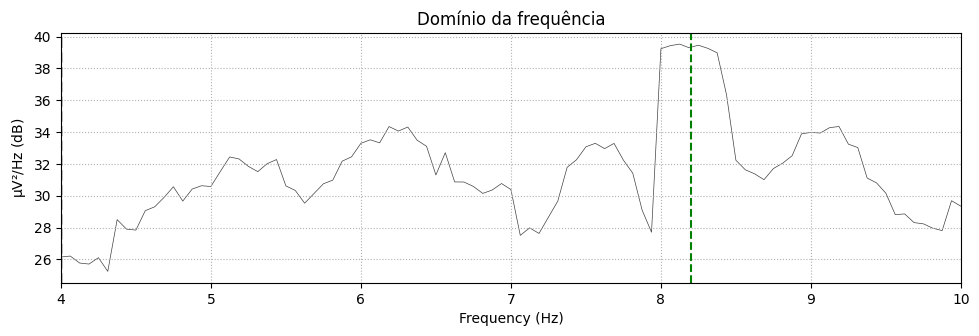

Need more than one channel to make topography for eeg. Disabling interactivity.



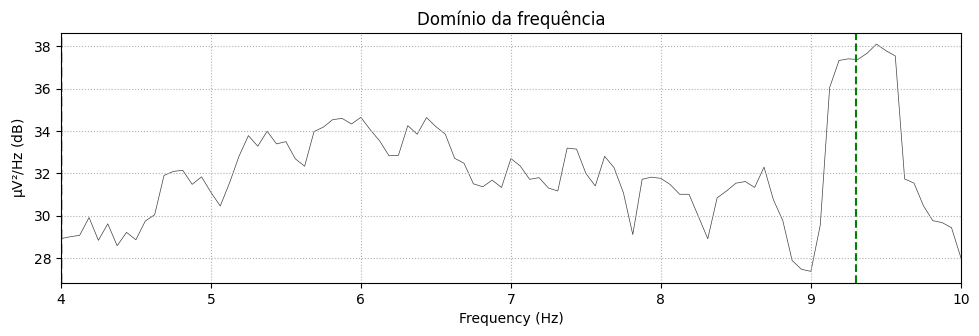

Need more than one channel to make topography for eeg. Disabling interactivity.



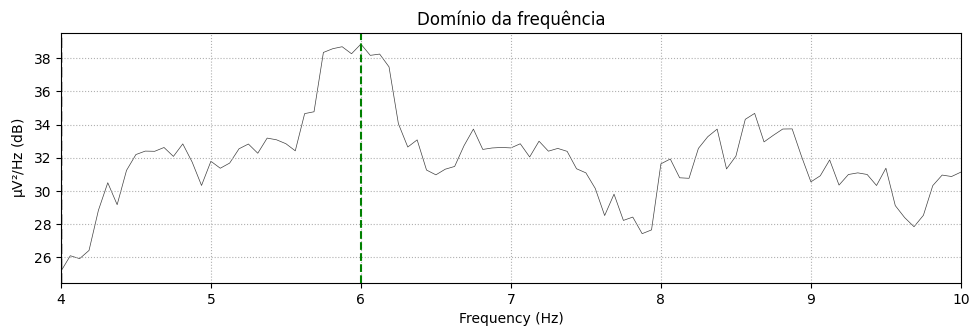

Need more than one channel to make topography for eeg. Disabling interactivity.



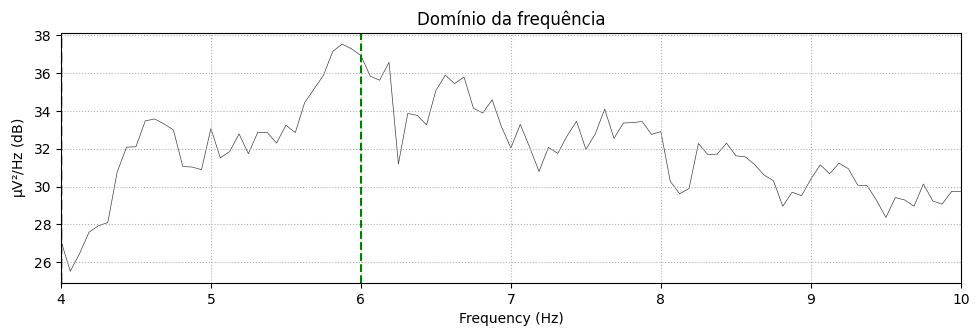

Need more than one channel to make topography for eeg. Disabling interactivity.



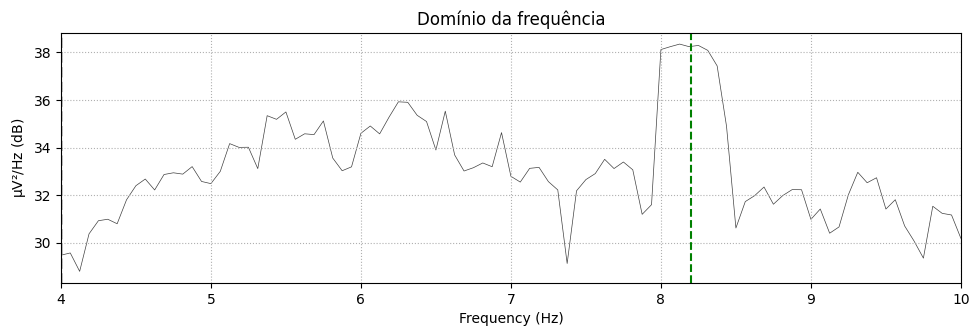

Need more than one channel to make topography for eeg. Disabling interactivity.



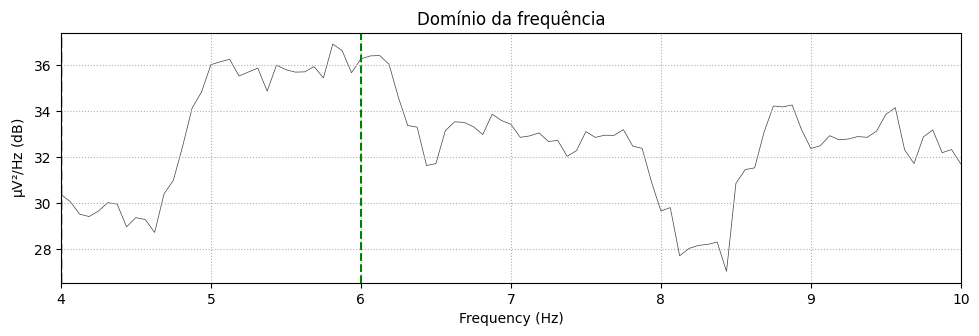

Need more than one channel to make topography for eeg. Disabling interactivity.



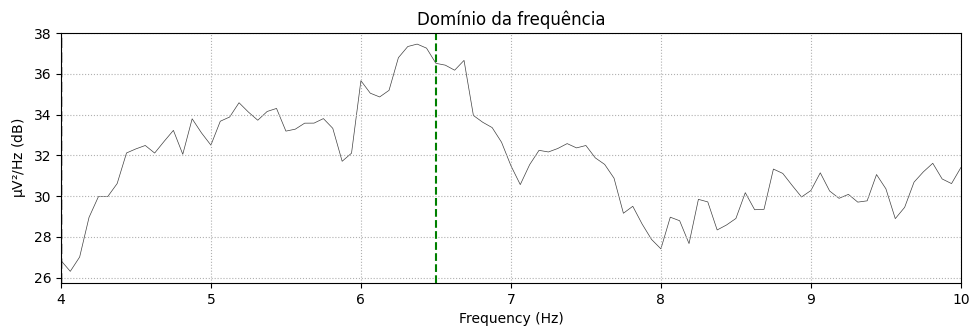

Need more than one channel to make topography for eeg. Disabling interactivity.



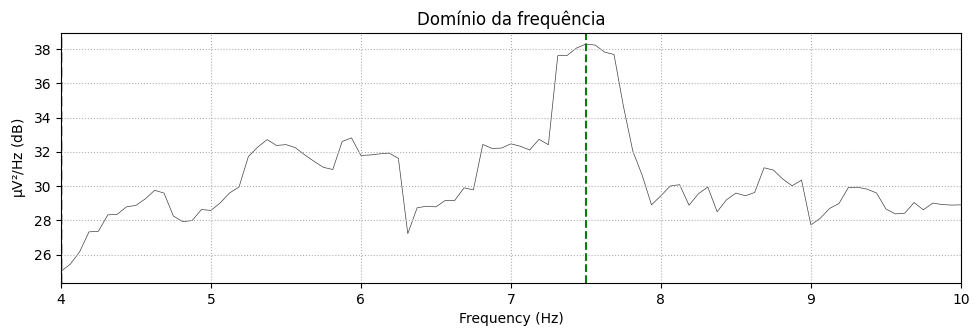

Need more than one channel to make topography for eeg. Disabling interactivity.



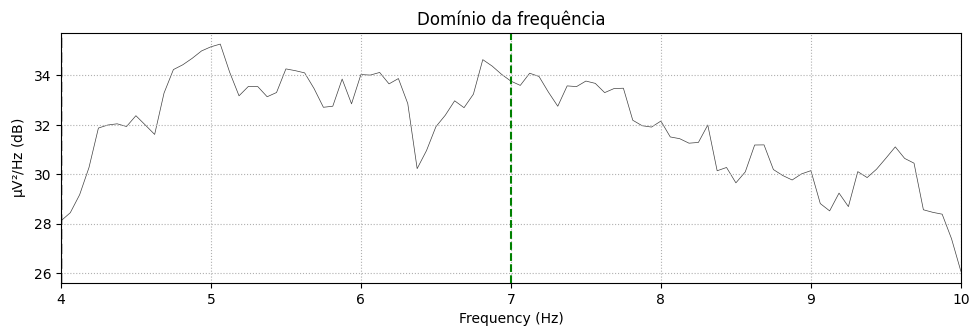

Need more than one channel to make topography for eeg. Disabling interactivity.



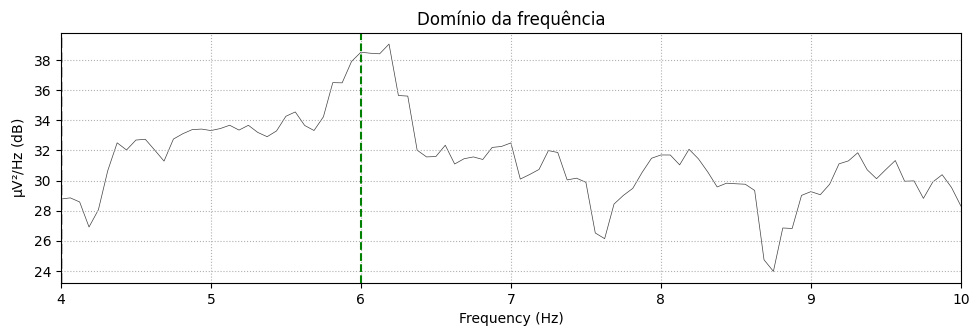

Need more than one channel to make topography for eeg. Disabling interactivity.



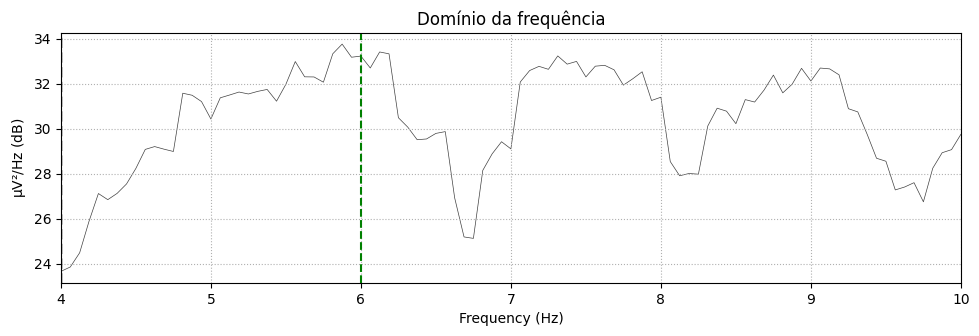

Need more than one channel to make topography for eeg. Disabling interactivity.



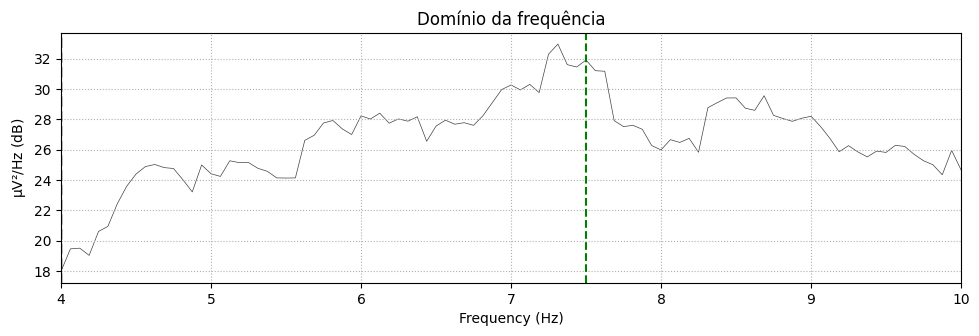

Need more than one channel to make topography for eeg. Disabling interactivity.



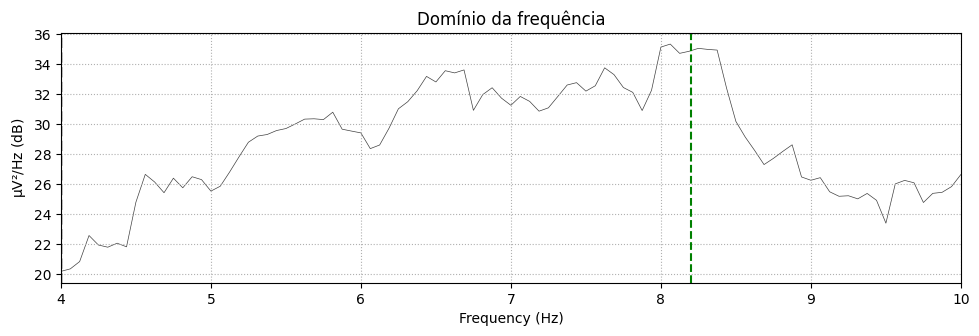

Need more than one channel to make topography for eeg. Disabling interactivity.



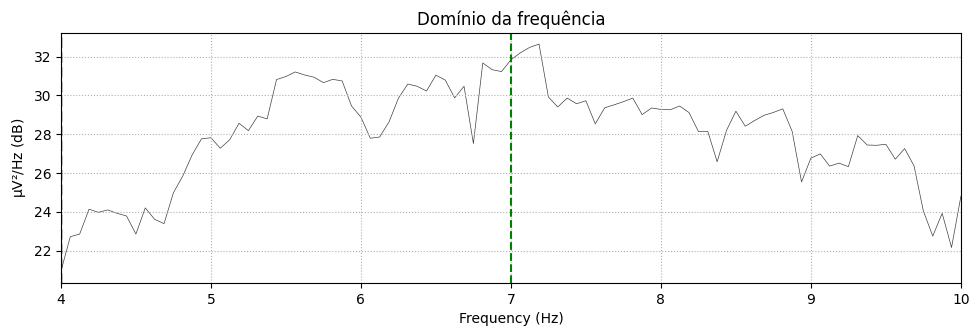

Need more than one channel to make topography for eeg. Disabling interactivity.



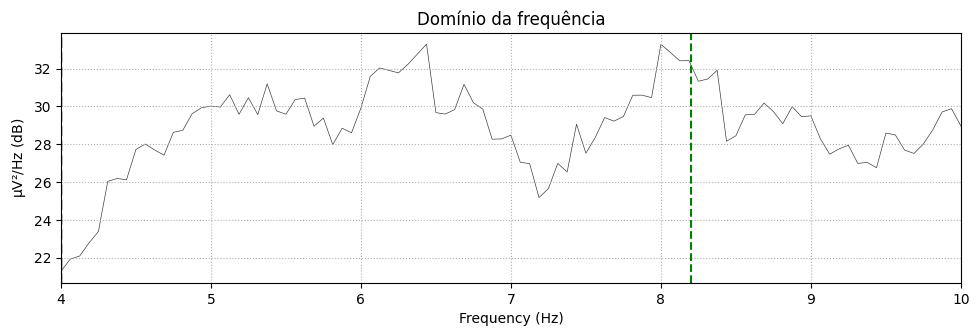

Need more than one channel to make topography for eeg. Disabling interactivity.



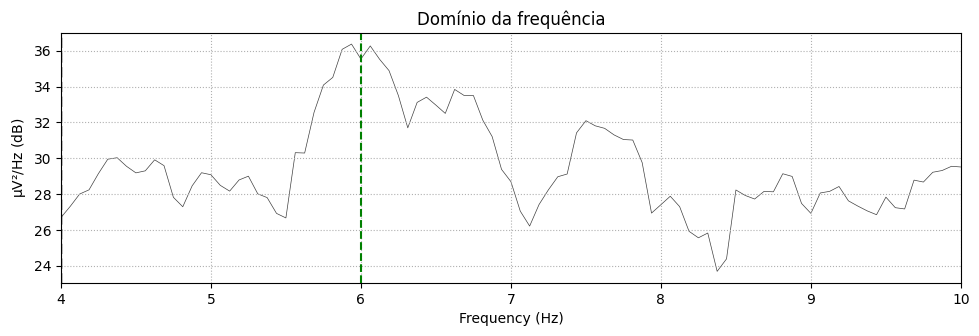

Need more than one channel to make topography for eeg. Disabling interactivity.



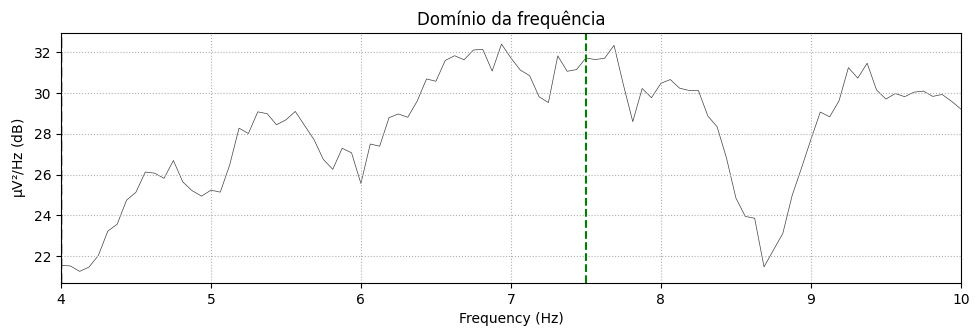

Need more than one channel to make topography for eeg. Disabling interactivity.



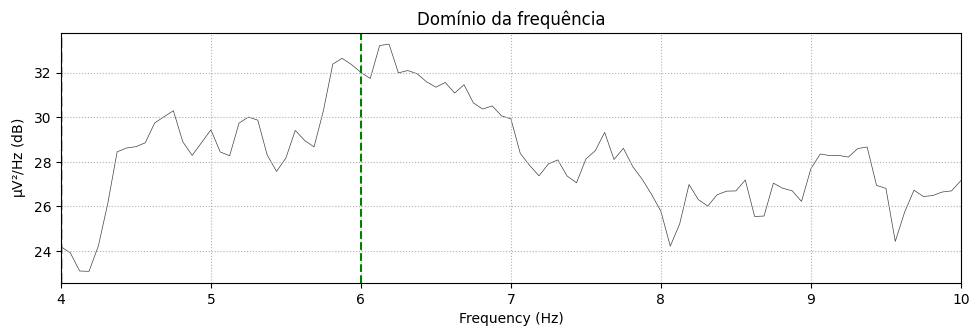

Need more than one channel to make topography for eeg. Disabling interactivity.



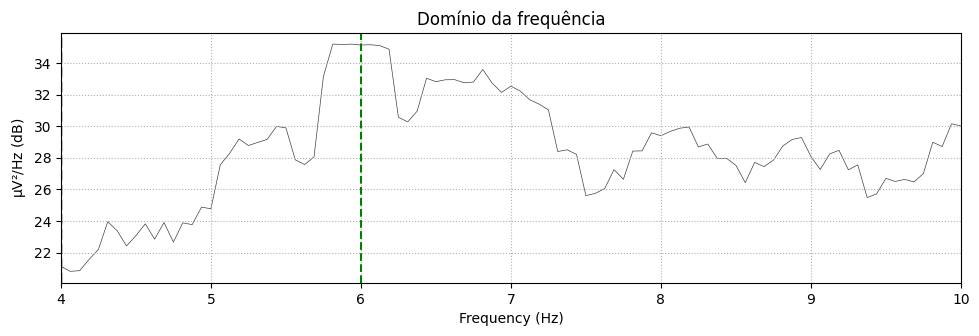

Need more than one channel to make topography for eeg. Disabling interactivity.



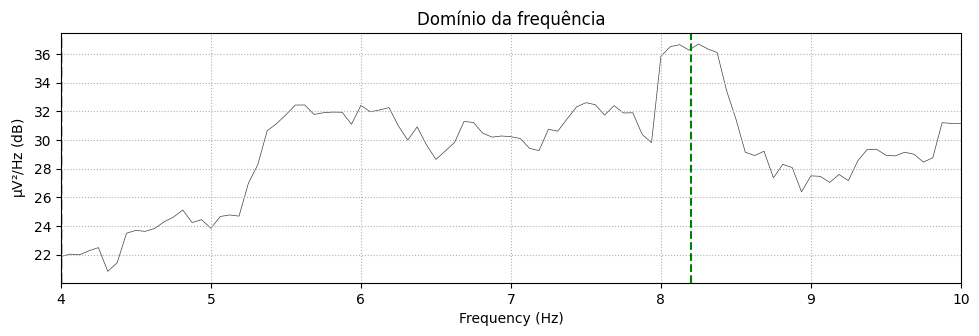

Need more than one channel to make topography for eeg. Disabling interactivity.



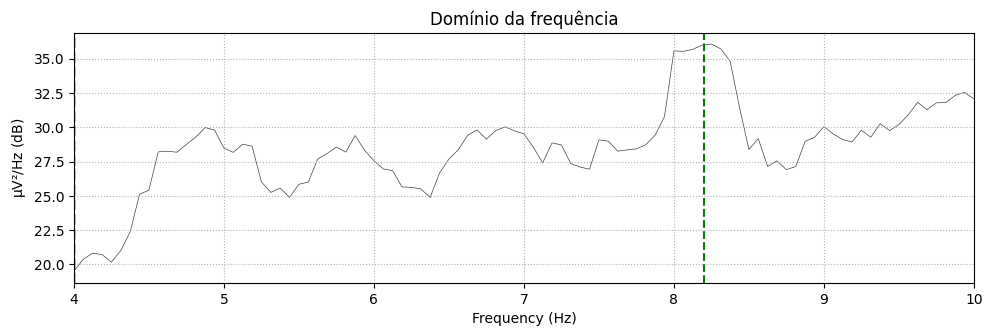

Need more than one channel to make topography for eeg. Disabling interactivity.



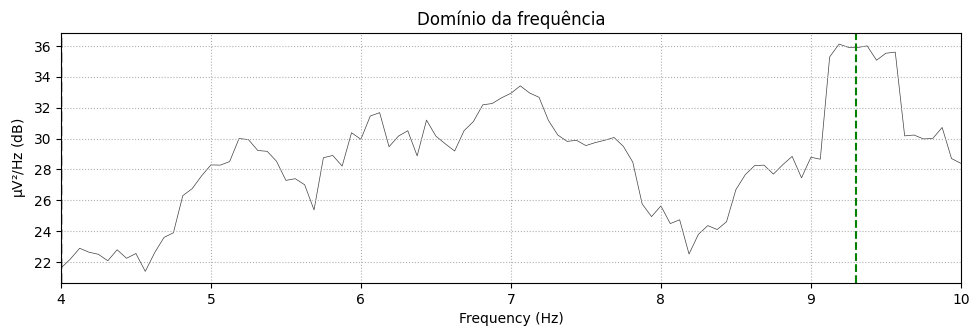

Need more than one channel to make topography for eeg. Disabling interactivity.



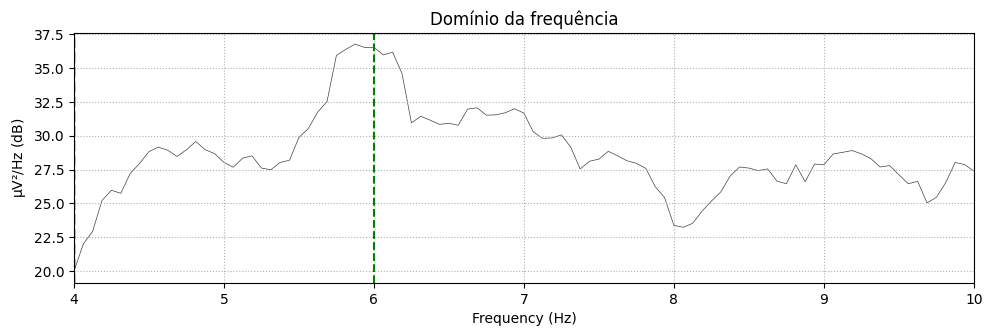

Need more than one channel to make topography for eeg. Disabling interactivity.



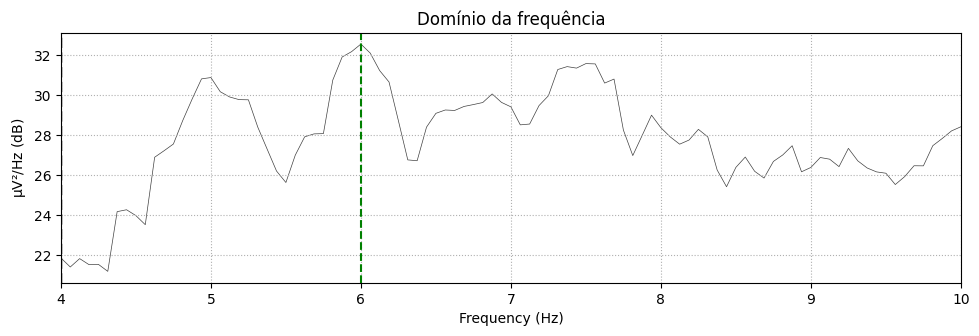

Need more than one channel to make topography for eeg. Disabling interactivity.



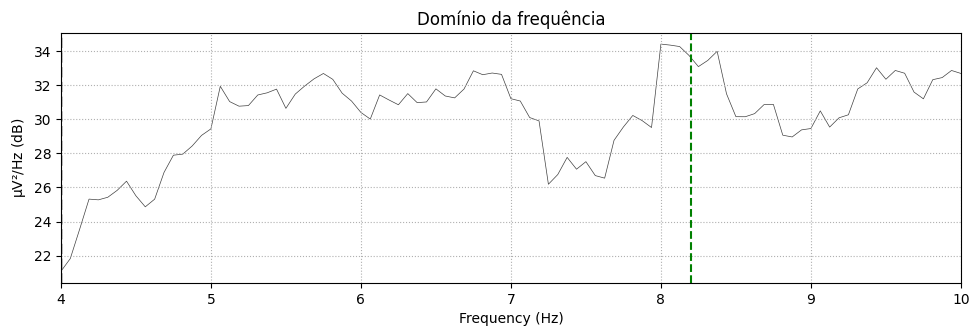

Need more than one channel to make topography for eeg. Disabling interactivity.



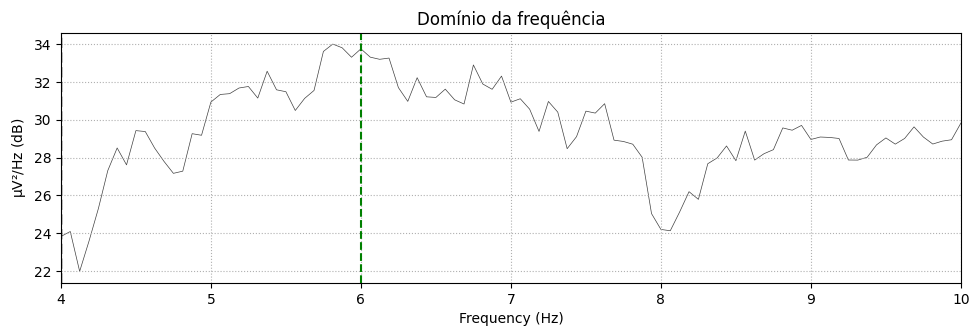

Need more than one channel to make topography for eeg. Disabling interactivity.



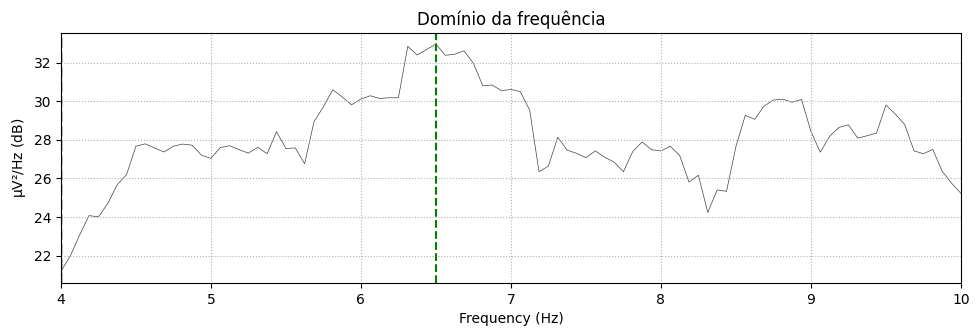

Need more than one channel to make topography for eeg. Disabling interactivity.



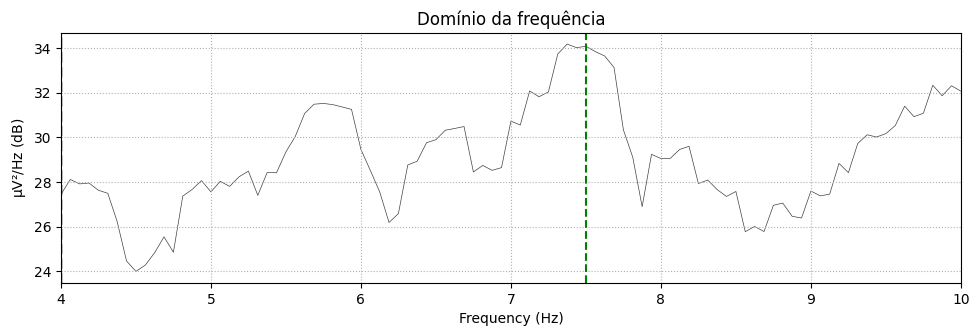

Need more than one channel to make topography for eeg. Disabling interactivity.



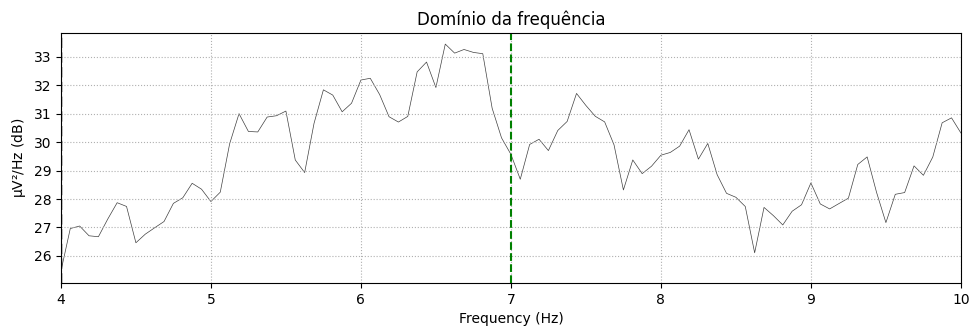

Need more than one channel to make topography for eeg. Disabling interactivity.



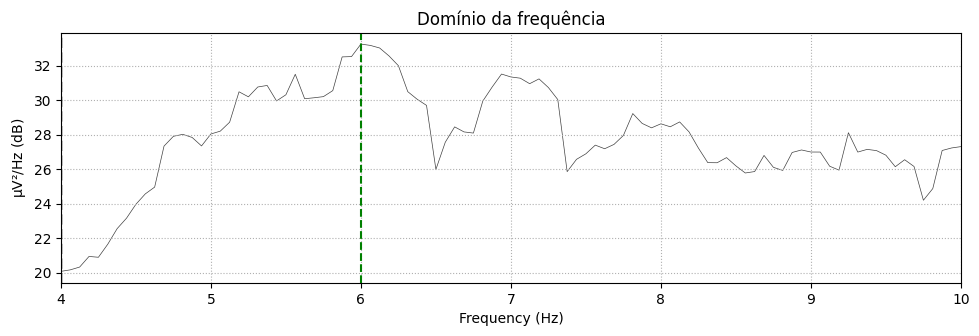

Need more than one channel to make topography for eeg. Disabling interactivity.



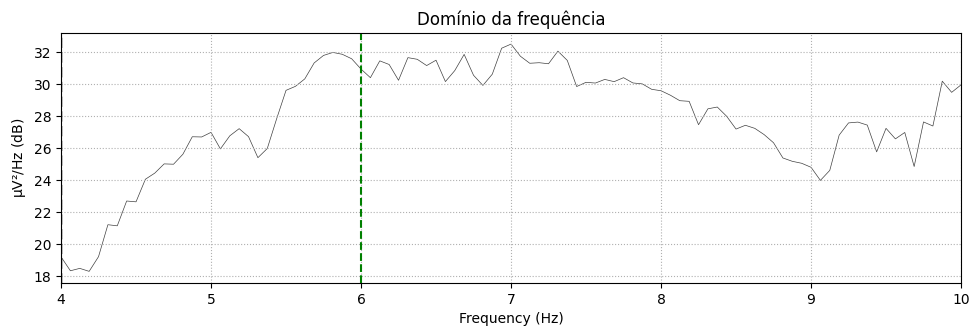

In [27]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=4, fmax=10,
                                   verbose=False) # ampliação do gráfico no domínio da frequência
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()